# Automated Resume Screening

### How to Run Code

To run the code, simply follow these steps:

1. Download [Dataset #1](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset) or [Dataset #2](https://www.kaggle.com/datasets/maitrip/resumes),
2. Change the CSV directories used to load in the CSV file in Sections 1 and 5 below (Ctrl+F for `DATA_PATH`).
3. Ensure all dependencies are installed (see Section 0 on Imports).

### NLP 6120 Final Project

Anuja Prakash Kolse, Oum Parikh, Alexander Wilcox

Prof. Uzair Ahmad

Spring 2024

Our project is designed to enhance the efficiency and fairness of the resume evaluation process by utilizing advanced unsupervised natural language processing (NLP) technologies. We focus on automating the comparison of resumes across a wide range of professions by calculating similarity scores with respect to various job descriptions and exemplary resumes. Our goal is to refine the preliminary selection of candidates, optimizing time management and minimizing unconscious biases that often occur in manual review.

We are conducting a comprehensive exploration of diverse vectorization methods to transform resumes into numerical embeddings. These embeddings are then leveraged to train a sophisticated classification model. Our dual achievements include the effective computation of resume similarity scores through innovative approaches and the development of a classifier capable of assigning a professional category to a given resume. We have employed techniques including Word2Vec, TF-IDF, and GloVe to facilitate these advancements.

### **0. Imports**

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import re
import string
import warnings
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec, KeyedVectors
from gensim.downloader import load
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    make_scorer
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [ ]:
# download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **1. Load Resume Dataset**

In [ ]:
DATA_DIR = '/content/drive/My Drive/NEU/Graduate/CS_6120/NLP_Project/Data/'
DATA_PATH = os.path.join(DATA_DIR, 'Dataset2_Resumes.csv')

df = pd.read_csv(
    DATA_PATH
)
df['Category'] = df['Category'].astype(str)
df['Resume'] = df['Resume'].astype(str)

print(f"- There are {format(len(df), ',')} total rows in df.")
df.head(3)

- There are 1,219 total rows in df.


ID Category                                             Resume
0   1       HR  b'John H. Smith, P.H.R.\n800-991-5187 | PO Box...
1   2       HR  b'Name Surname\nAddress\nMobile No/Email\nPERS...
2   3       HR  b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...

### **2. Visualize Resume Dataset**

In [ ]:
job_category = df['Category'].value_counts().reset_index()
job_category = job_category.rename(
    columns = {
        "Category": "Job Category",
        "count": "Count"
    }
)
print(f"- {format(len(job_category), ',')} total rows in job_category.")
job_category.head(25)

- 25 total rows in job_category.


Job Category  Count
0               Engineering    121
1    Information Technology    104
2                 Education    102
3          Health & Fitness     77
4                 Managment     74
5                Accountant     67
6                   Finance     66
7                  Advocate     61
8                     Sales     61
9             Digital Media     54
10                Designing     51
11                  Banking     48
12     Business Development     44
13                     Arts     43
14                       HR     41
15  Building & Construction     29
16               Automobile     27
17               Consultant     26
18                      BPO     25
19             Agricultural     24
20         Food & Beverages     22
21                  Apparel     14
22         Public Relations     13
23                 Aviation     13
24               Architects     12

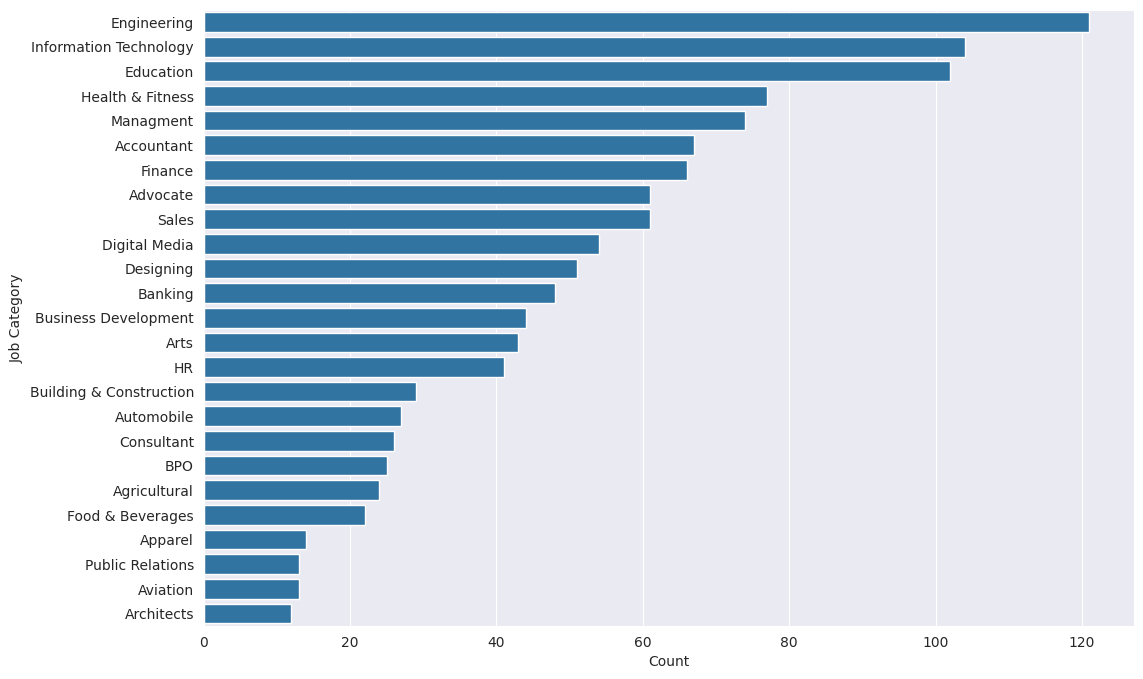

In [ ]:
plt.figure(
    figsize = (12,8)
)
sns.barplot(
    x = job_category['Count'],
    y = job_category['Job Category']
)
plt.show()

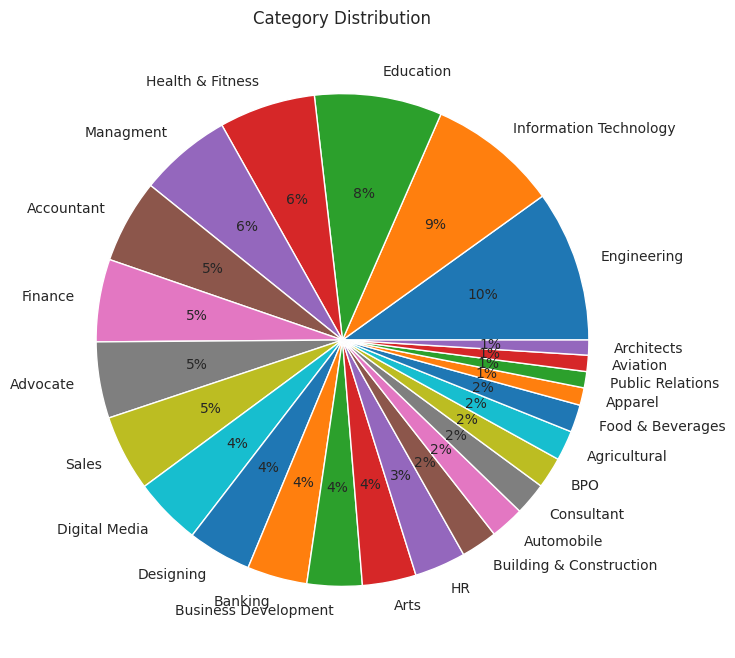

In [ ]:
plt.figure(
    figsize = (12,8)
)
plt.pie(
    job_category['Count'],
    labels = job_category['Job Category'],
    autopct = '%.0f%%'
)
plt.title('Category Distribution')
plt.show()

This pie chart above is a visualization of the distribution of various job categories within a certain dataset or population.

From this chart, we observe the following:

1. The largest single category is for Java Developer roles, making up 9% of the distribution.
2. Testing and Python Developer roles are also significant categories, comprising 7% and 6% respectively.
3. Several fields, including Web Designing, HR, Hadoop, Blockchain, ETL Developer, Operations Manager, Data Science, and Sales, each make up 4% of the distribution.
4. Other technical roles like DotNet Developer, Network Security Engineer, SAP Developer, and Civil Engineer are represented with smaller proportions ranging from 2% to 3%.
5. There are also categories for non-technical roles such as Advocate and PMO (Project Management Office), each with 2%.
6. The smallest identified categories, each with 3%, cover a range of jobs, including Mechanical Engineer, Arts, Database, Electrical Engineering, Health and Fitness, and Business Analyst.

### **3. Preprocessing Resume Data**

In [ ]:
def preprocess(
    text: str
) -> str:
    """
    Purpose: Prepares text for NLP tasks by normalizing it. This includes converting to lowercase,
        removing punctuation, tokenizing, filtering out stopwords, and lemmatizing.
    :param text: str representing raw text to be preprocessed.
    :return: str representing a processed string with basic normalization applied, suitable for
        downstream NLP tasks.
    """
    # lowercasing
    text = text.lower()

    # removing punctuation
    text = re.sub(
        pattern = f'[{string.punctuation}]',
        repl = '',
        string = text
    )

    # tokenization
    tokens = word_tokenize(
        text = text
    )

    # removing stopwords
    tokens = [
        token for token in tokens if token not in stopwords.words('english')
    ]

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(token) for token in tokens
    ]

    # joining tokens back to form a string
    return ' '.join(tokens)

The `preprocess` function defined above performs following operations:

- <ins>Lowercasing:</ins> Converts all characters in the text to lowercase. This is done to ensure that the same word in different cases (e.g., "Word" and "word") is treated as the same word.

- <ins>Removing Punctuation:</ins> Removes all punctuation marks from the text using a regular expression.

- <ins>Tokenization:</ins> Tokenization is a fundamental step in text processing as it breaks the text into manageable pieces for further analysis. This splits the text into individual words or tokens using the word_tokenize function from the nltk library.

- <ins>Removing Stopwords:</ins> Filters out common words that are considered "stopwords" (e.g., "the", "is", "and").

- <ins>Lemmatization:</ins> Reduces words to their base or root form using a WordNetLemmatizer. For example, "running" is lemmatized to "run". Lemmatization is performed here because it produces more meaningful and grammatically correct base forms.

- <ins>Joining Tokens Back:</ins> After processing, the tokens are joined back together into a single string, separated by spaces. This is done because some algorithms or vectorizers expect the input as a single string rather than a list of tokens.

The function returns the preprocessed text as a single string, ready for further processing or vectorization.

In [ ]:
# apply preprocessing function to resumes
df['Cleaned_Resume'] = df['Resume'].apply(
    preprocess
)

In [ ]:
df.head()

ID Category                                             Resume  \
0   1       HR  b'John H. Smith, P.H.R.\n800-991-5187 | PO Box...   
1   2       HR  b'Name Surname\nAddress\nMobile No/Email\nPERS...   
2   3       HR  b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...   
3   4       HR  b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...   
4   5       HR  b"HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert...   

                                      Cleaned_Resume  
0  bjohn h smith phr\n8009915187 po box 1673 call...  
1  bname surname\naddress\nmobile noemail\nperson...  
2  banthony brown\nhr assistant\nareas expertise\...  
3  bwwwdownloadmelacom\nsatheesh\nemail id\ncaree...  
4  bhuman resource director\n\xef\x82\xb7expert o...

In [ ]:
# Display the first 5 preprocessed resumes
print(df[['Resume', 'Cleaned_Resume']].head(5))

                                              Resume  \
0  b'John H. Smith, P.H.R.\n800-991-5187 | PO Box...   
1  b'Name Surname\nAddress\nMobile No/Email\nPERS...   
2  b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...   
3  b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...   
4  b"HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert...   

                                      Cleaned_Resume  
0  bjohn h smith phr\n8009915187 po box 1673 call...  
1  bname surname\naddress\nmobile noemail\nperson...  
2  banthony brown\nhr assistant\nareas expertise\...  
3  bwwwdownloadmelacom\nsatheesh\nemail id\ncaree...  
4  bhuman resource director\n\xef\x82\xb7expert o...  


Considering a few job descriptions for testing in `job_descriptions`.

In [ ]:
# job descriptions
job_descriptions = [
    "Data scientist with experience in Python and machine learning",
    "Web developer with knowledge in HTML, CSS, and JavaScript",
    "Graphic designer with expertise in Adobe Creative Suite"
]

### **4. Vectorization**

#### 4.1) TF-IDF Vectorizer

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (i.e., a corpus). It is commonly used in text mining and information retrieval to transform text into a meaningful representation of numbers which can be used for various machine learning algorithms. The TF-IDF value increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. This helps to adjust for the fact that some words appear more frequently in general.

TF-IDF consists of two components:
1. <ins>Term Frequency (TF):</ins> This measures how frequently a term occurs in a document. It is calculated as the number of times a term appears in a document divided by the total number of terms in that document.

2. <ins>Inverse Document Frequency (IDF):</ins> This measures how important a term is within the entire corpus. It is calculated as the logarithm of the number of documents divided by the number of documents that contain the term.

The TF-IDF value is calculated by multiplying TF and IDF: <b><i>TF-IDF = TF × IDF</i></b>

This value is high for terms that are very specific and characteristic of a particular document in the corpus, and low for terms that are common across many documents. This helps in distinguishing the relevance of terms in a specific document compared to their relevance across a broader set of documents.

In [ ]:
class TfIdf:

    def __init__(
        self,
        flag_sublinear_tf: bool,
        no_features: int
    ) -> None:
        """
        Purpose: Initializes the TF-IDF vectorizer with specified configurations.
        :param flag_sublinear_tf: bool indicating if sublinear tf scaling is applied.
        :param no_features: int indicating the maximum number of features to consider.
        :return: None.
        """
        # instantiate TF-IDF vectorizer attribute
        self.vectorizer = TfidfVectorizer(
            sublinear_tf = flag_sublinear_tf,
            stop_words = 'english',
            max_features = no_features
        )

    def test_job_descriptions(
        self,
        df: pd.DataFrame,
        job_descriptions: List[str]
    ) -> None:
        """
        Purpose: Fits the vectorizer on resumes and evaluates job descriptions
            against them using cosine similarity.
        :param df: pd.DataFrame containing resumes and their details.
        :param job_descriptions: List[str] of job descriptions to compare
            against the resumes.
        :return: None.
        """
        # fit vectorizer on resumes
        tfidf_matrix = self.vectorizer.fit_transform(
            raw_documents = df['Cleaned_Resume']
        )

        # loop through each job description
        for i, job_description in enumerate(job_descriptions):

            # preprocess job description
            job_description = preprocess(
                text = job_description
            )

            # transform job description using the fitted vectorizer
            job_vec = self.vectorizer.transform(
                raw_documents = [job_description]
            )

            # calculate cosine similarity between job description and resumes
            similarity_scores = cosine_similarity(
                job_vec, tfidf_matrix
            )

            # add similarity scores to dataframe
            df[f'Similarity_Job_{i+1}'] = similarity_scores[0]

            # rank resumes based on similarity scores
            ranked_resumes = df.sort_values(
                by = f'Similarity_Job_{i+1}',
                ascending = False
            )

            # print top 5 shortlisted resumes for each job
            print(f"Top 5 resumes for Job {i+1} ({job_description}):")
            print(ranked_resumes[['Category', f'Similarity_Job_{i+1}']].head(5))
            print("\n")

**Parameters Used:**

1. <ins>`sublinear_tf`:</ins> When set to True, this parameter applies a sublinear transformation to the term frequency (TF) part of the TF-IDF calculation. Specifically, it uses 1+log(TF) instead of TF itself. This transformation is used to reduce the influence of very high term frequencies, as they may not be as informative as lower frequencies. It helps to prevent a few highly frequent terms from dominating the TF-IDF values.

2. <ins>`stop_words`:</ins> Specifies a list of words that should be ignored in the analysis. In this case, "english" indicates that the built-in list of English stopwords provided by scikit-learn should be used.

3. <ins>`max_features`:</ins> Limits the number of features (i.e., unique words or terms) to consider when creating the TF-IDF matrix. In this case, max_features=1500 means that only the top 1,500 terms ordered by term frequency across the corpus will be included in the matrix. This can be useful for reducing the dimensionality of the data and focusing on the most relevant terms.

##### TF-IDF Vectorizer, Experiment #1:

Hyperparameters:
  - `sublinear_tf = True`
  - `max_features = 1500`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = True,
    no_features = 1_500
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_1
263  Information Technology          0.251242
662                   Sales          0.169410
890             Engineering          0.154818
886             Engineering          0.145827
177  Information Technology          0.143816


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_2
233  Information Technology          0.358196
77                Designing          0.316296
182  Information Technology          0.308035
232  Information Technology          0.299531
201  Information Technology          0.290693


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
     Category  Similarity_Job_3
57  Designing          0.317480
69  Designing          0.281655
81  Designing          0.281530
72  Designing          0.281331
42  Designing          0.279408




##### TF-IDF Vectorizer, Experiment #2:

Hyperparameters:
  - `sublinear_tf = False`
  - `max_features = 1500`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = False,
    no_features = 1_500
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_1
263  Information Technology          0.268913
223  Information Technology          0.263007
886             Engineering          0.182773
435    Business Development          0.168389
177  Information Technology          0.135074


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_2
239  Information Technology          0.478944
66                Designing          0.375619
240  Information Technology          0.352166
77                Designing          0.322800
233  Information Technology          0.314723


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
     Category  Similarity_Job_3
69  Designing          0.466181
57  Designing          0.377903
56  Designing          0.373112
70  Designing          0.363288
81  Designing          0.311167




##### TF-IDF Vectorizer, Experiment #3:

Hyperparameters:
  - `sublinear_tf = True`
  - `max_features = 500`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = True,
    no_features = 500
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_1
263  Information Technology          0.266782
270               Education          0.212704
456    Business Development          0.205518
223  Information Technology          0.188592
247  Information Technology          0.186766


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_2
239  Information Technology          0.486096
232  Information Technology          0.474514
233  Information Technology          0.378484
262  Information Technology          0.374999
169  Information Technology          0.367096


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
      Category  Similarity_Job_3
56   Designing          0.373058
63   Designing          0.357465
861    Apparel          0.340397
43   Designing          0.299883
860    Apparel          0.291018




##### TF-IDF Vectorizer, Experiment #4:

Hyperparameters:
  - `sublinear_tf = False`
  - `max_features = 500`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = False,
    no_features = 500
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_1
223  Information Technology          0.430039
263  Information Technology          0.302053
435    Business Development          0.272507
270               Education          0.258876
448    Business Development          0.221925


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_2
239  Information Technology          0.774535
66                Designing          0.577986
262  Information Technology          0.472530
240  Information Technology          0.452246
232  Information Technology          0.436878


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
       Category  Similarity_Job_3
56    Designing          0.611369
87    Designing          0.384846
70    Designing          0.383893
1198       Arts          0.373457
74    Designing          0.351396




##### TF-IDF Vectorizer, Experiment #5:

Hyperparameters:
  - `sublinear_tf = False`
  - `max_features = 1000`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = False,
    no_features = 1_000
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_1
223  Information Technology          0.394294
435    Business Development          0.252247
263  Information Technology          0.227756
448    Business Development          0.198354
270               Education          0.173841


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_2
239  Information Technology          0.582519
77                Designing          0.397864
66                Designing          0.375153
232  Information Technology          0.358512
262  Information Technology          0.322782


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
     Category  Similarity_Job_3
69  Designing          0.476179
57  Designing          0.431520
70  Designing          0.402370
56  Designing          0.380884
81  Designing          0.324319




##### TF-IDF Vectorizer, Experiment #6:

Hyperparameters:
  - `sublinear_tf = False`
  - `max_features = 250`

In [ ]:
obj_tfidf = TfIdf(
    flag_sublinear_tf = True,
    no_features = 250
)
obj_tfidf.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_1
223  Information Technology          0.416665
675              Consultant          0.266383
252  Information Technology          0.244735
448    Business Development          0.244495
634                   Sales          0.243324


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_2
239  Information Technology          0.397435
232  Information Technology          0.384478
251  Information Technology          0.340907
218  Information Technology          0.332085
169  Information Technology          0.317956


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
    Category  Similarity_Job_3
0         HR               0.0
810  Finance               0.0
817  Finance               0.0
816  Finance               0.0
815  Finance               0.0




##### TF-IDF Vectorizer Experiment Observations:

Based on the experiments above, we find out that setting the hyperparameter `sublinear_tf` to False gives better result than setting it to True which means that not applying the transformation helps in calculating the similarity score. But if we increase the number of features, we find that the similarity does not relate to the correct category and thus we can conclude that the optimal hyperparameters are:
- `sublinear_tf = False`
- `max_features = 500`

#### 4.2) GloVe Vectorization

GloVe (Global Vectors for Word Representation) is a model for distributed word representation. It is an unsupervised learning algorithm developed by Stanford University researchers to generate word embeddings by aggregating global word-word co-occurrence statistics from a corpus. The resulting embeddings capture both the semantic and syntactic information of words, making them useful for various natural language processing (NLP) tasks.

Stepwise approach to how the GloVe model generates word embeddings:

1. <ins>Collect Data:</ins> Gather a large text corpus that represents the language you want to model.

2. <ins>Build a Co-occurrence Matrix:</ins> Create a matrix where each element $X_{i,j}$ represents the number of times word $i$ occurs in the context of word $j$ within a specified window size. The window size determines how many words surrounding a target word will be considered as its context.

3. <ins>Calculate Probabilities:</ins> Transform the co-occurrence counts in the matrix into probabilities. Specifically, for each word pair $(i,j)$, calculate the probability $P_{i,j}$ that word $i$ appears in the context of word $j$.

4. <ins>Define a Loss Function:</ins> The loss function in GloVe is designed to minimize the difference between the dot product of the embeddings of two words and the logarithm of their co-occurrence probability. The function also includes weighting factors to prevent overemphasis on rare or too frequent word pairs.

5. <ins>Train the Model:</ins> Optimize the loss function to learn the word vectors. This involves adjusting the embeddings for each word in a way that the dot product of the embeddings of two words approximates the logarithm of their co-occurrence probability.

6. <ins>Extract Word Embeddings:</ins> After training, the resulting word vectors are extracted. These vectors capture both the syntactic and semantic information of words based on their co-occurrence statistics in the corpus.

In [ ]:
# load a pre-trained GloVe model through gensim
model_glove = load(
    'glove-wiki-gigaword-300'
)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
# function to vectorize text using the pre-trained model
def vectorize_text(
    text: str,
    model
) -> np.ndarray:
    """
    Purpose: Converts input text into a fixed-size vector using a pre-trained
        GloVe model by averaging the vectors of the words present in the text.
    :param text: str representing text to be vectorized.
    :param model: A pre-trained GloVe model loaded via gensim's KeyedVectors.
    :return: np.ndarrray representing the averaged vector of the text. Returns
        a zero vector if none of the words in the text are in the model's vocabulary.
    """
    words = word_tokenize(
        text = text
    )
    valid_words = [
        word for word in words if word in model.key_to_index
    ]

    if valid_words:
        return np.mean(
            model[valid_words],
            axis = 0
        )
    else:
        return np.zeros(model.vector_size)

In [ ]:
# vectorize resumes using GloVe
df['Vec_Resume_Glove'] = df['Cleaned_Resume'].apply(
    lambda resume_text: vectorize_text(
        text = resume_text,
        model = model_glove
    )
)

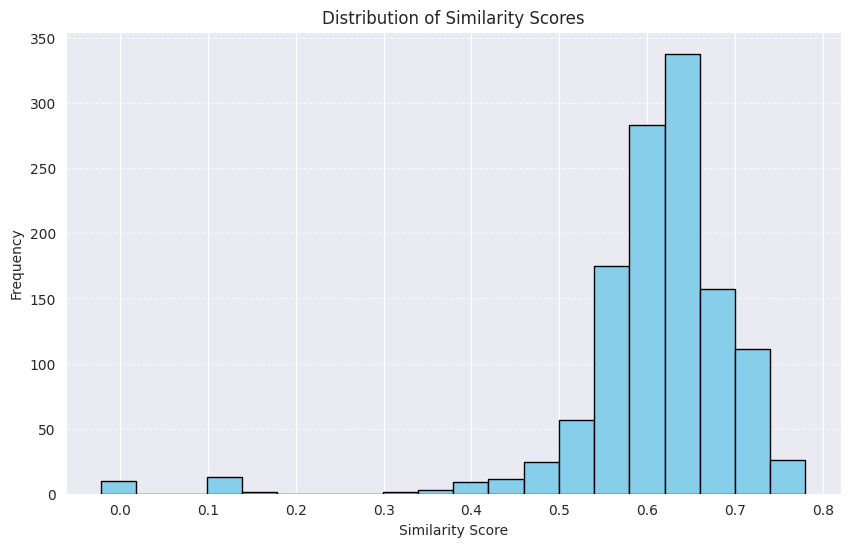

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_Glove_1
263  Information Technology                0.780207
247  Information Technology                0.776494
176  Information Technology                0.771046
801                 Finance                0.765901
208  Information Technology                0.761772




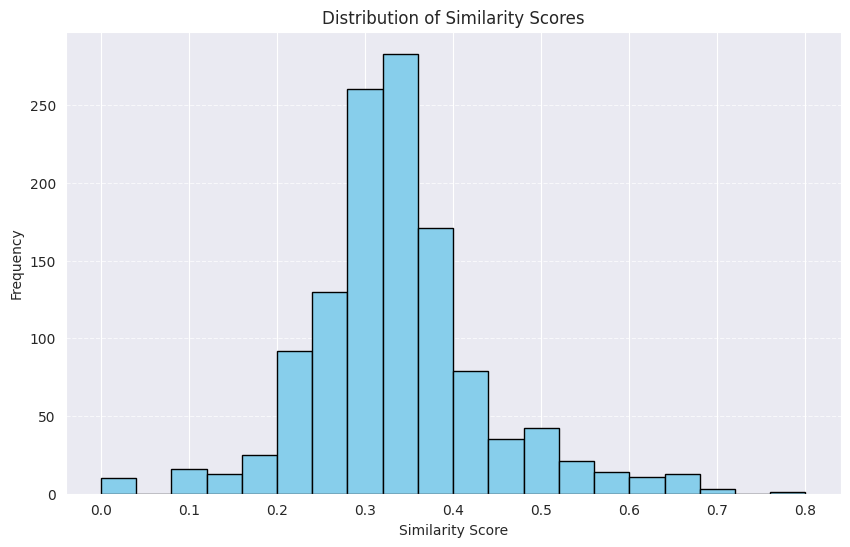

Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_Glove_2
77                Designing                0.799955
194  Information Technology                0.704649
232  Information Technology                0.694915
251  Information Technology                0.693870
66                Designing                0.679404




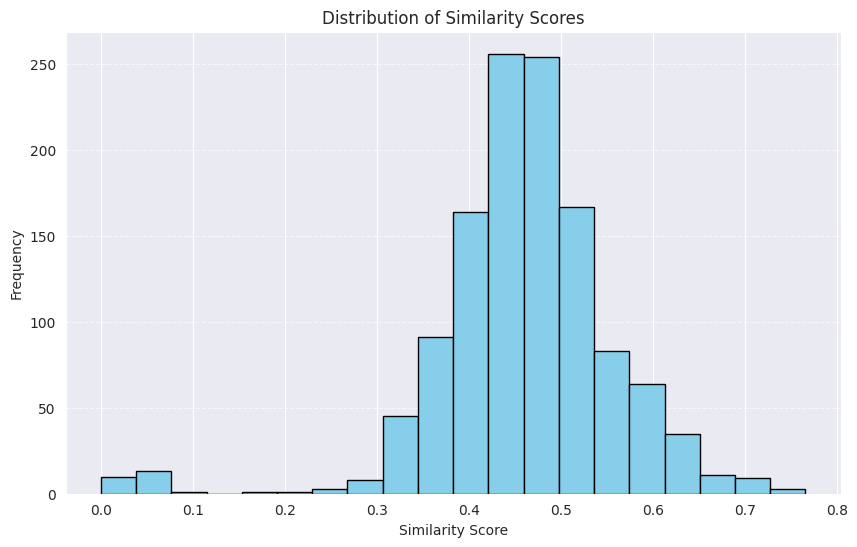

Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
     Category  Similarity_Job_Glove_3
72  Designing                0.766003
69  Designing                0.742973
57  Designing                0.742614
42  Designing                0.727254
88  Designing                0.712900




In [ ]:
# loop through each job description
for i, job_description in enumerate(job_descriptions):

    # preprocess job description
    job_description = preprocess(
        text = job_description
    )

    # transform job description using the fitted vectorizer
    job_vec = vectorize_text(
        text = job_description,
        model = model_glove
    )

    # calculate cosine similarity between the job description and the resumes
    similarity_scores = [
        np.dot(job_vec, resume_vec) / (np.linalg.norm(job_vec) * np.linalg.norm(resume_vec))
        if np.linalg.norm(resume_vec) != 0
        else 0
        for resume_vec in df['Vec_Resume_Glove']
    ]

    # create plot
    plt.figure(
        figsize = (10, 6)
    )
    plt.hist(
        x = similarity_scores,
        bins = 20,
        color = 'skyblue',
        edgecolor = 'black'
    )
    plt.title('Distribution of Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.grid(
        axis = 'y',
        linestyle = '--',
        alpha = 0.7
    )
    plt.show()

    # add similarity scores to DataFrame
    df[f'Similarity_Job_Glove_{i+1}'] = similarity_scores

    # rank resumes based on similarity scores
    ranked_resumes = df.sort_values(
        by = f'Similarity_Job_Glove_{i+1}',
        ascending = False
    )

    # display top 5 shortlisted resumes for each job
    print(f"Top 5 resumes for Job {i+1} ({job_description}):")
    print(ranked_resumes[['Category', f'Similarity_Job_Glove_{i+1}']].head(5))
    print("\n")

#### 4.3) Word2Vec Vectorization

Word2Vec is a popular technique in Natural Language Processing (NLP) used to create word embeddings, which are vector representations of words. These embeddings capture semantic and syntactic information about words, allowing them to be used effectively in various NLP tasks.

Word2Vec works by training a shallow neural network to reconstruct linguistic contexts of words in a corpus. It does this by either predicting a word based on its context (Continuous Bag of Words, or CBOW) or predicting the context based on a word (Skip-Gram). Through this process, words that appear in similar contexts tend to have similar embeddings, capturing their semantic relationships. The models use a sliding window approach, moving across the text corpus and considering each word (or a subset of words) along with its neighboring context words to perform their respective prediction tasks.

In [ ]:
class CustomWord2Vec:

    def __init__(
        self,
        df: pd.DataFrame,
        vector_size: int,
        window: int,
        min_count: int,
        workers: int,
        sg: int
    ) -> None:
        """
        Purpose: Initializes a Word2Vec model with specific configurations and trains it on
            tokenized text from a DataFrame.
        :param df: pd.DataFrame containing resumes and their details.
        :param vector_size: int representing the dimensionality of the word vectors.
        :param window: int representing the maximum distance between the current and predicted
            word within a sentence.
        :param min_count: int representing the threshold below which all words with a total
            frequency less than min_count are ignored.
        :param workers: int representing the total number of worker threads to use.
        :param sg: int representing the training algorithm (1 for Skip-Gram; otherwise CBOW).
        :return: None.
        """
        self.model_word2vec = Word2Vec(
            sentences = df['Tokenized'],
            vector_size = vector_size,
            window = window,
            min_count = min_count,
            workers = workers,
            sg = sg
        )

    def document_vector(
        self,
        doc: List[str]
    ) -> np.ndarray:
        """
        Purpose: Vectorizes a document by averaging the vectors of words present in the
            document, using the trained Word2Vec model.
        :param doc: List[str] representing tokenized words in a document.
        :return: np.ndarray representing the averaged word vector for the document.
            Returns a zero vector if document has no valid words.
        """
        # remove out-of-vocabulary words
        doc = [
            word for word in doc
            if word in self.model_word2vec.wv.index_to_key
        ]
        if doc:
            return np.mean(
                self.model_word2vec.wv[doc],
                axis = 0
            )
        else:
            return np.zeros(self.model_word2vec.vector_size)

    def test_job_descriptions(
        self,
        df: pd.DataFrame,
        job_descriptions: List[str]
    ) -> None:
        """
        Purpose: Compares job descriptions against resumes by vectorizing them and calculating cosine
            similarity, then ranks resumes for each job.
        :param df: pd.DataFrame containing resumes with a 'Tokenized' column for vectorization.
        :param job_descriptions: List of strings with job descriptions to compare against resumes.
        :return: None.
        """
        # create document vectors for each resume
        df['Vec_Resume_Word2Vec'] = df['Tokenized'].apply(
            lambda resume: self.document_vector(
                doc = resume
            )
        )

        # loop through each job description
        for i, job_description in enumerate(job_descriptions):

            # preprocess the job description
            job_description = preprocess(
                text = job_description
            )

            # transform job description using the fitted vectorizer
            job_vec = self.document_vector(
                doc = simple_preprocess(
                    doc = job_description
                )
            )

            # calculate cosine similarity between the job description and the resumes
            similarity_scores = [
                np.dot(job_vec, doc_vec) / (np.linalg.norm(job_vec) * np.linalg.norm(doc_vec))
                if np.linalg.norm(doc_vec) != 0
                else 0
                for doc_vec in df['Vec_Resume_Word2Vec']
            ]

            # add similarity scores to the dataframe
            df[f'Similarity_Job_Word2Vec_{i+1}'] = similarity_scores

            # rank resumes based on similarity scores
            ranked_resumes = df.sort_values(
                by = f'Similarity_Job_Word2Vec_{i+1}',
                ascending = False
            )

            # display top 5 shortlisted resumes for each job
            print(f"Top 5 resumes for Job {i+1} ({job_description}):")
            print(ranked_resumes[['Category', f'Similarity_Job_Word2Vec_{i+1}']].head(5))
            print("\n")

**Parameters Used:**

1. <ins>`sentences`:</ins> This is the input data for training the model. In this case, it is a list of tokenized sentences. Each sentence is a list of words.

2. <ins>`vector_size`:</ins> This specifies the dimensionality of the word embeddings. In this case, each word will be represented as a 50-dimensional vector. A higher dimensionality can capture more information but may also require more data to train effectively.

3. <ins>`window`:</ins> This parameter defines the maximum distance between the current and predicted word within a sentence. In this case, a window size of 7 means that the model will consider a context of 7 words to the left and 7 words to the right of the target word when making predictions in the Skip-gram model.

4. <ins>`min_count`:</ins> This parameter specifies the minimum frequency count of words. Words that appear fewer than min_count times across all sentences will be ignored during training. In this case, min_count=1 means that no words will be ignored based on frequency.

5. <ins>`workers`:</ins> This parameter determines the number of worker threads used to train the model. More workers can speed up training on multi-core machines. In this case, 4 worker threads will be used.

6. <ins>`sg`:</ins> This parameter specifies the training algorithm. When sg=1, the Skip-Gram model is used; otherwise, the Continuous Bag of Words (CBOW) model is used.

In [ ]:
# tokenize and preprocess the text
df['Tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: simple_preprocess(
        doc = resume
    )
)

##### Word2Vec Vectorizer, Experiment #1:

Hyperparameters:

- `vector_size = 50`
- `window = 5`
- `min_count = 1`
- `workers = 4`
- `sg = 1`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 50,
    window = 5,
    min_count = 1,
    workers = 4,
    sg = 1
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_Word2Vec_1
247  Information Technology                   0.923209
195  Information Technology                   0.922282
177  Information Technology                   0.921168
801                 Finance                   0.919402
207  Information Technology                   0.916911


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_Word2Vec_2
251  Information Technology                   0.921875
194  Information Technology                   0.916064
196  Information Technology                   0.909956
240  Information Technology                   0.900172
77                Designing                   0.898722


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
                   Category  Similarity_Job_Word2Vec_3
56                Designing                   0.924012
57  

##### Word2Vec Vectorizer, Experiment #2:

Hyperparameters:

- `vector_size = 50`
- `window = 7`
- `min_count = 1`
- `workers = 4`
- `sg = 1`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 50,
    window = 7,
    min_count = 1,
    workers = 4,
    sg = 1
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_Word2Vec_1
247  Information Technology                   0.918234
801                 Finance                   0.914805
177  Information Technology                   0.909280
100               Managment                   0.908709
195  Information Technology                   0.908405


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_Word2Vec_2
194  Information Technology                   0.913493
251  Information Technology                   0.910240
196  Information Technology                   0.905590
240  Information Technology                   0.896562
77                Designing                   0.895490


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
                   Category  Similarity_Job_Word2Vec_3
56                Designing                   0.923674
57  

##### Word2Vec Vectorizer, Experiment #3:

Hyperparameters:

- `vector_size = 50`
- `window = 3`
- `min_count = 1`
- `workers = 4`
- `sg = 1`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 50,
    window = 3,
    min_count = 1,
    workers = 4,
    sg = 1
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_Word2Vec_1
247  Information Technology                   0.918056
801                 Finance                   0.916113
195  Information Technology                   0.914060
177  Information Technology                   0.913505
448    Business Development                   0.910956


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_Word2Vec_2
251  Information Technology                   0.918595
194  Information Technology                   0.912157
196  Information Technology                   0.903654
240  Information Technology                   0.900956
77                Designing                   0.896273


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
                   Category  Similarity_Job_Word2Vec_3
56                Designing                   0.927868
57  

##### Word2Vec Vectorizer, Experiment #4:

Hyperparameters:

- `vector_size = 100`
- `window = 5`
- `min_count = 1`
- `workers = 4`
- `sg = 1`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 100,
    window = 5,
    min_count = 1,
    workers = 4,
    sg = 1
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_Word2Vec_1
247  Information Technology                   0.908439
177  Information Technology                   0.905552
195  Information Technology                   0.904976
801                 Finance                   0.904055
886             Engineering                   0.902364


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_Word2Vec_2
251  Information Technology                   0.913295
194  Information Technology                   0.906452
196  Information Technology                   0.904922
240  Information Technology                   0.894546
77                Designing                   0.891767


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
                   Category  Similarity_Job_Word2Vec_3
56                Designing                   0.919343
57  

##### Word2Vec Vectorizer, Experiment #5:

Hyperparameters:

- `vector_size = 100`
- `window = 3`
- `min_count = 1`
- `workers = 4`
- `sg = 1`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 100,
    window = 3,
    min_count = 1,
    workers = 4,
    sg = 1
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_Word2Vec_1
247  Information Technology                   0.924194
801                 Finance                   0.919215
195  Information Technology                   0.917480
448    Business Development                   0.913916
177  Information Technology                   0.913761


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_Word2Vec_2
251  Information Technology                   0.916171
194  Information Technology                   0.907817
196  Information Technology                   0.906556
77                Designing                   0.898785
240  Information Technology                   0.898399


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
                   Category  Similarity_Job_Word2Vec_3
56                Designing                   0.923577
240 

##### Word2Vec Vectorizer, Experiment #6:

Hyperparameters:

- `vector_size = 50`
- `window = 3`
- `min_count = 1`
- `workers = 4`
- `sg = 0`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 50,
    window = 3,
    min_count = 1,
    workers = 4,
    sg = 0
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_Word2Vec_1
174  Information Technology                   0.937485
448    Business Development                   0.932517
247  Information Technology                   0.932225
88                Designing                   0.932139
196  Information Technology                   0.931926


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_Word2Vec_2
251  Information Technology                   0.921076
194  Information Technology                   0.907281
196  Information Technology                   0.906051
174  Information Technology                   0.905693
240  Information Technology                   0.904605


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
                   Category  Similarity_Job_Word2Vec_3
196  Information Technology                   0.966562
251 

##### Word2Vec Vectorizer, Experiment #7:

Hyperparameters:

- `vector_size = 50`
- `window = 5`
- `min_count = 1`
- `workers = 4`
- `sg = 0`

In [ ]:
obj_word2vec = CustomWord2Vec(
    df = df,
    vector_size = 50,
    window = 5,
    min_count = 1,
    workers = 4,
    sg = 0
)
obj_word2vec.test_job_descriptions(
    df = df,
    job_descriptions = job_descriptions
)

Top 5 resumes for Job 1 (data scientist experience python machine learning):
                   Category  Similarity_Job_Word2Vec_1
174  Information Technology                   0.926678
251  Information Technology                   0.926571
196  Information Technology                   0.924438
247  Information Technology                   0.922972
801                 Finance                   0.922780


Top 5 resumes for Job 2 (web developer knowledge html cs javascript):
                   Category  Similarity_Job_Word2Vec_2
251  Information Technology                   0.911516
194  Information Technology                   0.895912
196  Information Technology                   0.893887
240  Information Technology                   0.893237
174  Information Technology                   0.892860


Top 5 resumes for Job 3 (graphic designer expertise adobe creative suite):
                   Category  Similarity_Job_Word2Vec_3
196  Information Technology                   0.962532
251 

##### Word2Vec Vectorizer Experiment Observations:

Based on the experiments above, optimal parameters were:
- `vector_size = 50`
- `window = 3`

We can also observe that the Skip-Gram approach performs better than CBOW model.

### **5. Modeling**

In [ ]:
DATA_DIR = '/content/drive/My Drive/NEU/Graduate/CS_6120/NLP_Project/Data/'
DATA_PATH = os.path.join(DATA_DIR, 'Dataset2_Resumes.csv')

df = pd.read_csv(
    DATA_PATH
)
df['Cleaned_Resume'] = df['Resume'].apply(
    preprocess
)

In [ ]:
# encode the data
label = LabelEncoder()
df['Target'] = label.fit_transform(
    df['Category']
)

In [ ]:
df.head(3)

ID Category                                             Resume  \
0   1       HR  b'John H. Smith, P.H.R.\n800-991-5187 | PO Box...   
1   2       HR  b'Name Surname\nAddress\nMobile No/Email\nPERS...   
2   3       HR  b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...   

                                      Cleaned_Resume  Target  
0  bjohn h smith phr\n8009915187 po box 1673 call...      19  
1  bname surname\naddress\nmobile noemail\nperson...      19  
2  banthony brown\nhr assistant\nareas expertise\...      19

#### 5.1) Classification via One-vs-Rest

##### 5.1.1) One-vs-Rest Classifier, TF-IDF Vectorization

In [ ]:
# vectorizing cleaned columns
text = df['Cleaned_Resume'].values
target = df['Target'].values

tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf = False,
    stop_words = 'english',
    max_features = 500
)
tfidf_vectorizer.fit(
    raw_documents = text
)
features = tfidf_vectorizer.transform(
    raw_documents = text
)

print(f"features.shape = {features.shape}")

features.shape = (1219, 500)


In [ ]:
# define model
model_tfidf = OneVsRestClassifier(
    estimator = KNeighborsClassifier()
)

In [ ]:
# define CV procedure
cv = KFold(
    n_splits = 5,
    random_state = 21,
    shuffle = True
)

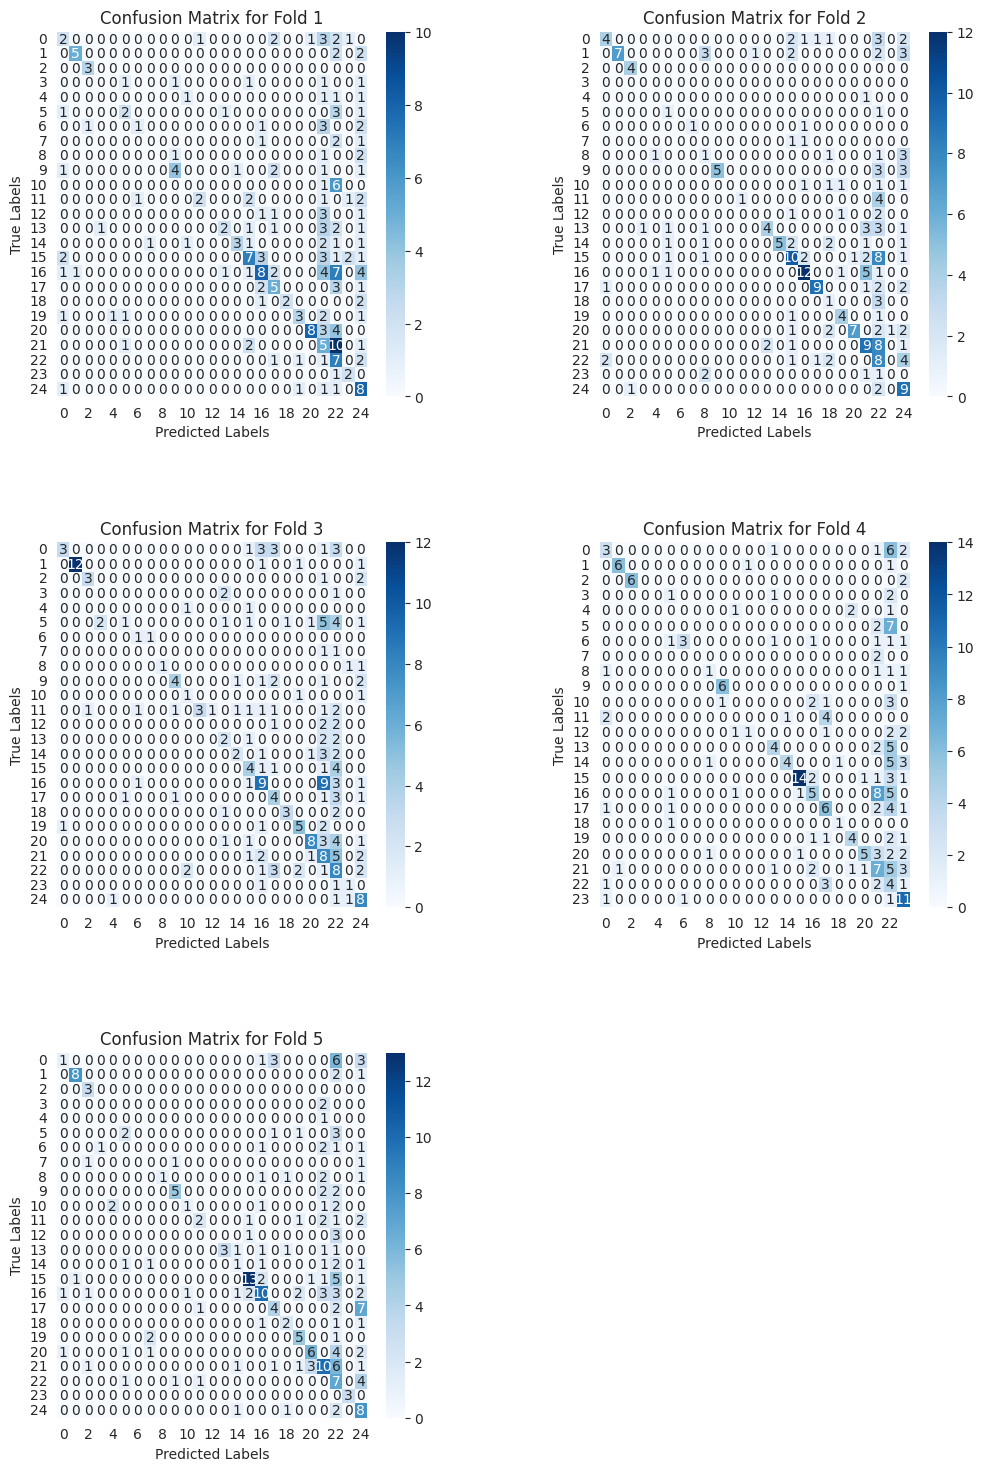

In [ ]:
# store each fold's performance metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(features)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = target[train_index], target[test_index]

    # train model
    model_tfidf.fit(
        X_train,
        y_train
    )

    # prediction
    y_pred = model_tfidf.predict(
        X_test
    )

    # calculate confusion matrix
    conf_matrix = confusion_matrix(
        y_true = y_test,
        y_pred = y_pred
    )

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(
        accuracy_score(y_test, y_pred)
    )
    precisions.append(
        precision_score(y_test, y_pred, average = 'weighted')
    )
    recalls.append(
        recall_score(y_test, y_pred, average = 'weighted')
    )
    f1_scores.append(
        f1_score(y_test, y_pred, average = 'weighted')
    )

# hiding any unused subplots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')

plt.show()

In [ ]:
# calculate and print average performance metrics
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1_score = np.mean(f1_scores)

print(f"Average Validation Accuracy: {avg_accuracy * 100:.1f}%")
print(f"Average Validation Precision: {avg_precision * 100:.1f}%")
print(f"Average Validation Recall: {avg_recall * 100:.1f}%")
print(f"Average Validation F1 Score: {avg_f1_score * 100:.1f}%")

Average Validation Accuracy: 37.4%
Average Validation Precision: 48.4%
Average Validation Recall: 37.4%
Average Validation F1 Score: 38.4%


##### 5.1.2) One-vs-Rest Classifier, Word2Vec Vectorization

In [ ]:
# tokenize and preprocess the text
df['tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: simple_preprocess(
        doc = resume
    )
)

# train Word2Vec model
model = Word2Vec(
    sentences=df['tokenized'],
    vector_size=50,
    window=3,
    min_count=1,
    workers=4,
    sg=1
)

# define function to create a vector for a document
def document_vector(doc):
    """Generates a document vector by averaging the word vectors of the words in the document."""
    valid_words = [
        word for word in doc if word in model.wv.index_to_key
    ]
    if valid_words:
        return np.mean(model.wv[valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

# create document vectors for each resume
df['doc_vector'] = df['tokenized'].apply(
    lambda tokenized_resume: document_vector(
        doc = tokenized_resume
    )
)

# prepare data for modeling
X_word2vec = np.array(df['doc_vector'].tolist())
y = df['Category']

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(y)

# define CV procedure
cv = KFold(
    n_splits = 5,
    random_state = 21,
    shuffle = True
)

# define model
model_word_2_vec = OneVsRestClassifier(
    estimator = KNeighborsClassifier()
)

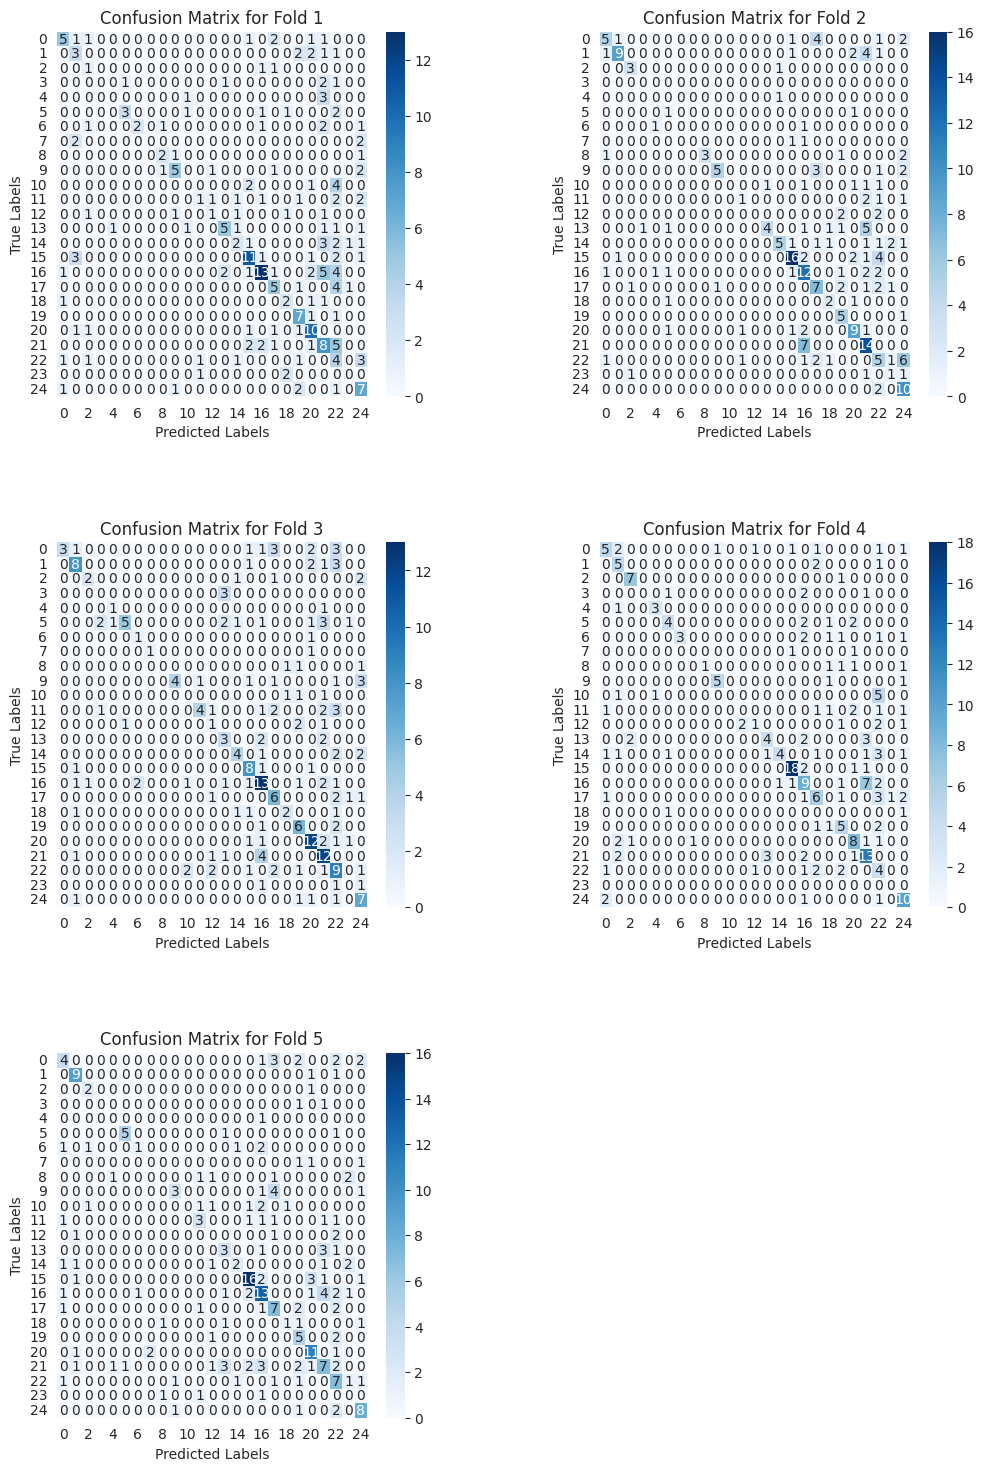

In [ ]:
# store each fold's performance metrics
accuracies, precisions, recalls, f1_scores = [], [], [], []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(X_word2vec)):
    X_train, X_test = X_word2vec[train_index], X_word2vec[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # train model
    model_word_2_vec.fit(X_train, y_train)

    # prediction
    y_pred = model_word_2_vec.predict(X_test)

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(
        accuracy_score(y_test, y_pred)
    )
    precisions.append(
        precision_score(y_test, y_pred, average='weighted')
    )
    recalls.append(
        recall_score(y_test, y_pred, average='weighted')
    )
    f1_scores.append(
        f1_score(y_test, y_pred, average='weighted')
    )

# hiding any unused subplots and show plots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')
plt.show()

In [ ]:
# calculate and print average performance metrics
print(f"Average Validation Accuracy: {np.mean(accuracies) * 100:.1f}%")
print(f"Average Validation Precision: {np.mean(precisions) * 100:.1f}%")
print(f"Average Validation Recall: {np.mean(recalls) * 100:.1f}%")
print(f"Average Validation F1 Score: {np.mean(f1_scores) * 100:.1f}%")

Average Validation Accuracy: 45.0%
Average Validation Precision: 49.0%
Average Validation Recall: 45.0%
Average Validation F1 Score: 44.1%


##### 5.1.3) One-vs-Rest Classifier, GloVe Vectorization

In [ ]:
# Tokenize and preprocess the text
df['tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: word_tokenize(
        text = resume
    )
)

# vectorize resumes using GloVe
df['Vec_Resume_Glove'] = df['Cleaned_Resume'].apply(
    lambda resume: vectorize_text(
        text = resume,
        model = model_glove
    )
)

In [ ]:
# prepare data for modeling
X_glove = np.array(df['Vec_Resume_Glove'].tolist())
y = df['Category']

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(
    y
)

# define model
model_glove_training = OneVsRestClassifier(
    estimator = KNeighborsClassifier()
)

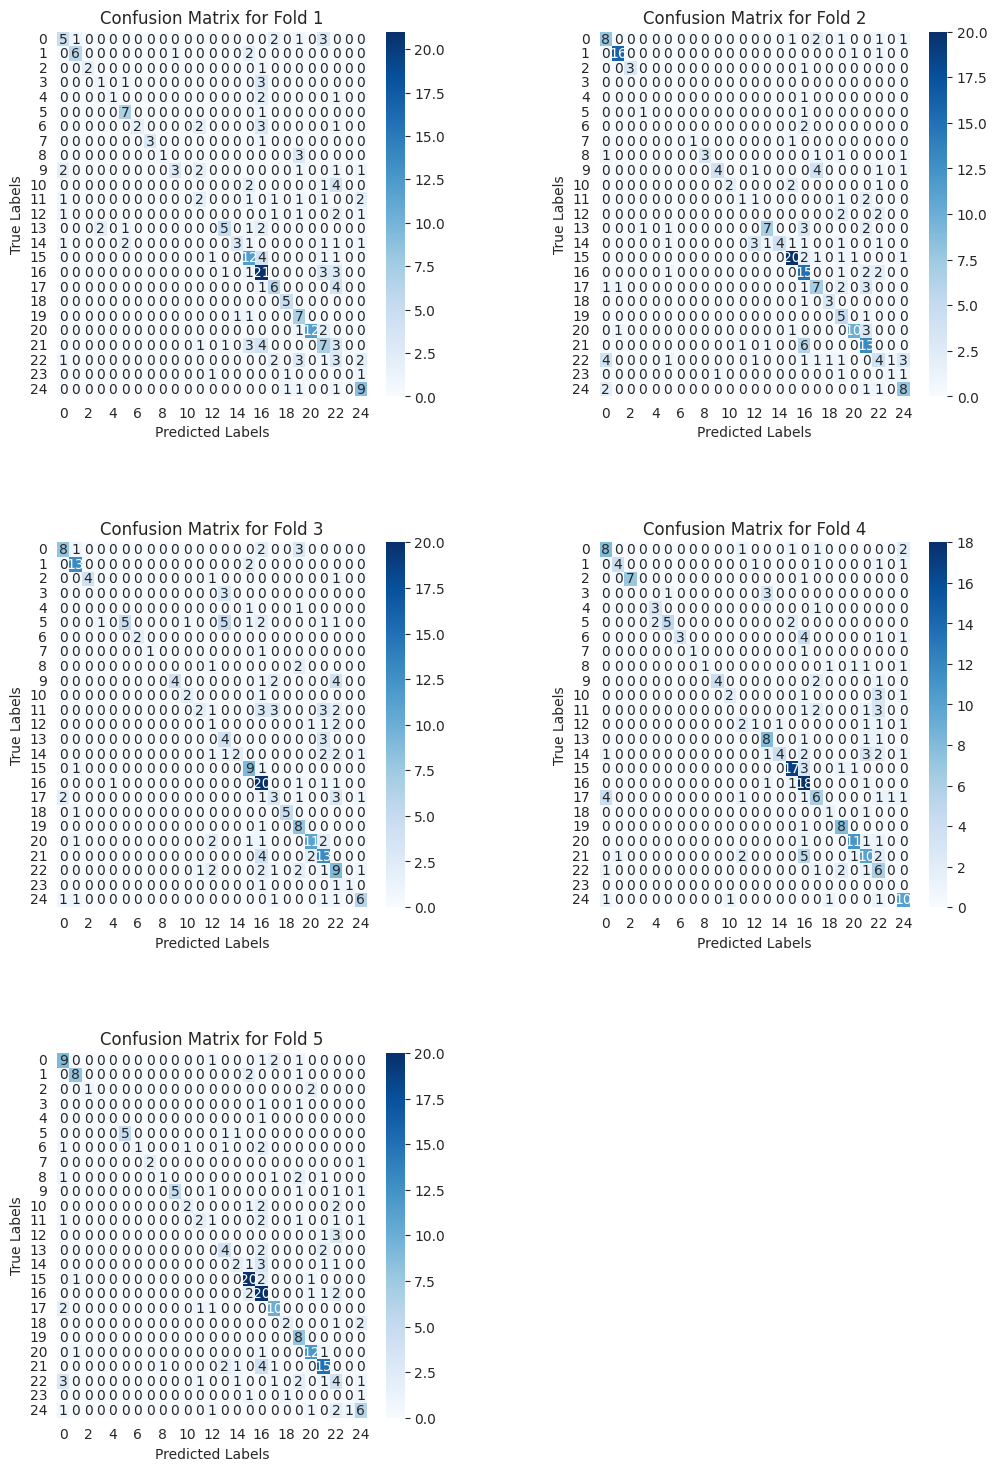

In [ ]:
# define CV procedure
cv = KFold(
    n_splits = 5,
    random_state = 21,
    shuffle = True
)

# store each fold's performance metrics
accuracies, precisions, recalls, f1_scores = [], [], [], []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(X_glove)):
    X_train, X_test = X_glove[train_index], X_glove[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # train model
    model_glove_training.fit(X_train, y_train)

    # prediction
    y_pred = model_glove_training.predict(X_test)

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# hiding any unused subplots; showing subplots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')
plt.show()

In [ ]:
# calculate and print average performance metrics
print(f"Average Validation Accuracy: {np.mean(accuracies) * 100:.1f}%")
print(f"Average Validation Precision: {np.mean(precisions) * 100:.1f}%")
print(f"Average Validation Recall: {np.mean(recalls) * 100:.1f}%")
print(f"Average Validation F1 Score: {np.mean(f1_scores) * 100:.1f}%")

Average Validation Accuracy: 54.8%
Average Validation Precision: 60.5%
Average Validation Recall: 54.8%
Average Validation F1 Score: 53.8%


#### 5.2) Classification via MLP

In [ ]:
# define hyperparameters
MLP_BATCH_SIZE = 64
MLP_HIDDEN_DIMS_LIST = [128]
MLP_DROPOUT = 0.3
MLP_LEARNING_RATE = 0.001
MLP_NUM_EPOCHS = 100

In [ ]:
# getting device for trianing MLP
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Device: \"{device}\".")

Device: "cpu".


##### 5.2.0) Define Reusable Functions to Make MLP, Train an MLP using SoftMax

In [ ]:
def make_mlp(
    input_dim: int,
    hidden_dims: List[int],
    output_dim: int,
    hidden_activation: nn.Module = nn.ReLU,
    dropout: float = 0.0
) -> nn.Sequential:
    """
    Purpose: Constructs an MLP model dynamically based on specified parameters.
    :param input_dim: int representing dimensionality of input features.
    :param hidden_dims: List[int] representing sizes of hidden layers.
    :param output_dim: int representing the size of the output layer.
    :param hidden_activation: nn.Module representing the hidden layer activation.
    :param dropout: Dropout rate for regularization between layers.
    :return: nn.Sequential representing a model consisting of the configured layers.
    """
    seq_list = []

    if len(hidden_dims) > 0:
        seq_list.append(nn.Linear(input_dim, hidden_dims[0]))
        seq_list.append(hidden_activation())

        if dropout > 0.0:
            seq_list.append(nn.Dropout(dropout))

        for i in range(1, len(hidden_dims)):
            seq_list.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            seq_list.append(hidden_activation())

            if dropout > 0.0:
                seq_list.append(nn.Dropout(dropout))

        seq_list.append(nn.Linear(hidden_dims[-1], output_dim))
    else:
        seq_list.append(nn.Linear(input_dim, output_dim))

    mlp = nn.Sequential(*seq_list)
    return mlp

In [ ]:
def train_and_validate_mlp(
    mlp_model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: optim.Optimizer,
    loss_function: nn.modules.loss._Loss,
    device: torch.device = torch.device('cpu'),
    epochs: int = 25
) -> Tuple:
    """
    Purpose: Trains and validates an MLP model over a specified number of epochs,
        computing training and validation metrics.
    :param mlp_model: The MLP neural network model to be trained and validated.
    :param train_loader: DataLoader for the training dataset.
    :param val_loader: DataLoader for the validation dataset.
    :param optimizer: optim.Optimizer algorithm used for gradient descent.
    :param loss_function: The loss function used to calculate the difference between
        the predicted and actual values.
    :param device: The device (CPU or GPU) on which the model and data are loaded for training.
    :param epochs: The total number of passes through the entire training dataset.
    :return: Tuple containing a list of train and validation true and predicted labels
    """
    # ensure model is on device
    mlp_model = mlp_model.to(device)

    # initialize metrics tracking
    best_train_accuracy = 0
    best_avg_train_loss = float('inf')
    best_avg_val_loss = float('inf')
    best_avg_val_loss_epoch_idx = -1
    best_val_accuracy = 0
    best_train_preds = []
    best_train_true = []

    # lists to store loss per epoch
    train_losses_list = []
    validation_losses_list = []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        epoch_idx = epoch + 1
        #print(f"Beginning epoch {epoch_idx}...")

        # ensure model is in train mode
        mlp_model.train()

        total_train_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0
        all_train_preds = []
        all_train_true = []

        for X_batch, y_batch in train_loader:

            # move tensors to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # reset gradients to 0 before starting backpropagation
            optimizer.zero_grad()

            # compute model predictions for the batch
            y_pred = mlp_model(
                X_batch
            )

            # computing loss for train batch
            train_batch_loss = loss_function(
                y_pred,
                y_batch
            )

            # backpropagate the batch loss and compute the gradients
            train_batch_loss.backward()

            # perform single optimization step by updating model's parameters based on gradients
            optimizer.step()

            # accumulating the epoch's total train loss
            total_train_loss += train_batch_loss.item()

            # calculate number of correct predictions
            predictions = torch.argmax(y_pred, dim = 1)
            correct_train_predictions += (predictions == y_batch).sum().item()

            total_train_predictions += y_batch.size(0)
            all_train_preds.extend(predictions.cpu().numpy())
            all_train_true.extend(y_batch.cpu().numpy())

        # tracking best train accuracy
        train_accuracy = accuracy_score(
            y_true = all_train_true,
            y_pred = all_train_preds
        )
        #train_accuracy = 100 * correct_train_predictions / total_train_predictions
        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy
            best_train_preds = all_train_preds.copy()
            best_train_true = all_train_true.copy()

        # calculate and print average train loss and accuracy
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses_list.append(avg_train_loss)
        if avg_train_loss < best_avg_train_loss:
            best_avg_train_loss = avg_train_loss
            #best_train_preds = all_train_preds.copy()
            #best_train_true = all_train_true.copy()

        # ------------------------------------------------------------------------------------------
        # BEGIN MODEL VALIDATION

        # switch model to evaluation mode
        mlp_model.eval()
        total_val_loss = 0
        correct_predictions = 0
        all_preds = []
        all_true = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                # move tensors to device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                # compute model's predictions for the validation data
                y_pred = mlp_model(
                    X_batch
                )

                # computing validation loss
                val_batch_loss = loss_function(
                    y_pred,
                    y_batch
                )

                # accumulating the epoch's total validation loss
                total_val_loss += val_batch_loss.item()

                # calculate number of correct predictions
                predictions = torch.argmax(y_pred, dim = 1)
                correct_predictions += (predictions == y_batch).sum().item()
                all_preds.extend(predictions.cpu().numpy())
                all_true.extend(y_batch.cpu().numpy())

        # calculate and print epoch's validation metrics
        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses_list.append(avg_val_loss)

        val_accuracy = accuracy_score(
            y_true = all_true,
            y_pred = all_preds
        )

        # tracking best val accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_val_preds = all_preds.copy()
            best_val_true = all_true.copy()

        # check to update best validation performance
        if avg_val_loss < best_avg_val_loss:
            best_avg_val_loss = avg_val_loss
            best_avg_val_loss_epoch_idx = epoch_idx
            #best_val_preds = all_preds.copy()
            #best_val_true = all_true.copy()

    # calculate confusion matrix for the best epoch
    conf_matrix = confusion_matrix(
        y_true = best_val_true,
        y_pred = best_val_preds
    )
    # plot confusion matrix
    plt.figure(
        figsize = (8, 6)
    )
    sns.heatmap(
        data = conf_matrix,
        annot = True,
        fmt = 'd',
        cmap = 'Blues'
    )
    plt.title(f'Confusion Matrix for Lowest Validation Loss (Epoch {best_avg_val_loss_epoch_idx})')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # plot training and validation losses
    plt.figure(
        figsize = (8, 4)
    )
    # Since epochs start from 1 and go up to 'epochs', we plot against epoch numbers directly
    plt.plot(
        range(1, epochs + 1),
        train_losses_list,
        label = 'Avg Training Loss'
        )
    plt.plot(
        range(1, epochs + 1),
        validation_losses_list,
        label = 'Avg Validation Loss'
    )
    plt.title('Training and Validation Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.xlim(
        left = 0.1,
        right=epochs + 0.1
    )
    plt.xticks(range(1, epochs + 1), rotation = 45, fontsize = 6)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return (best_train_true, best_train_preds, best_val_true, best_val_preds)

##### 5.2.1) MLP Classifier, TF-IDF Vectorization

Epochs: 100%|██████████| 100/100 [00:05<00:00, 19.81it/s]


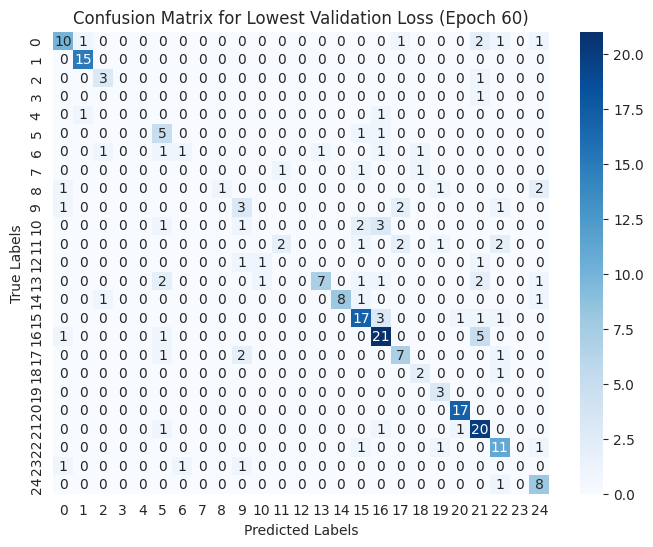

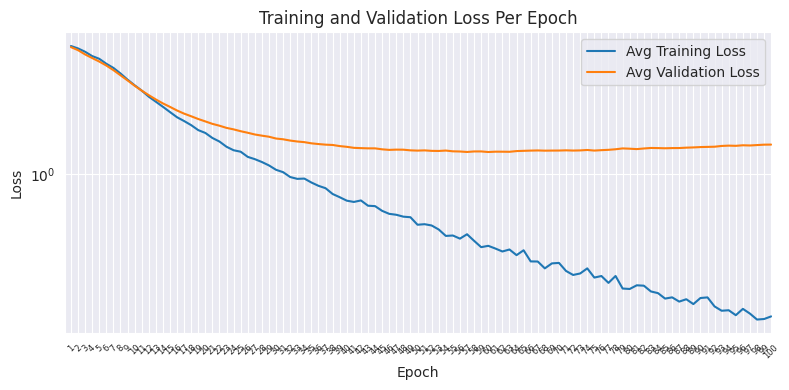

Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.46it/s]


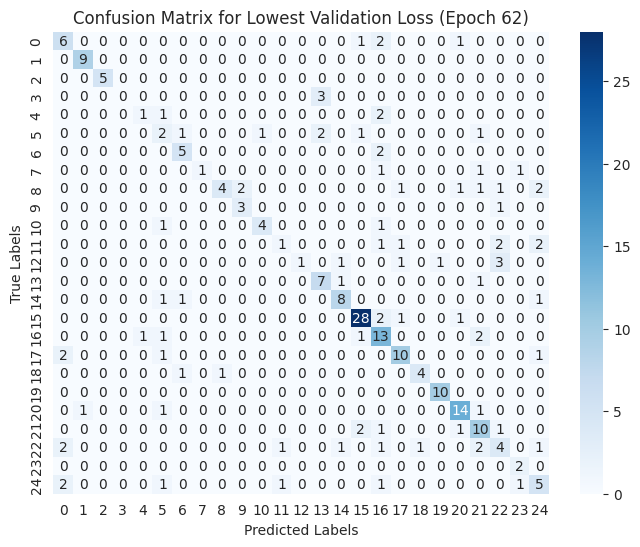

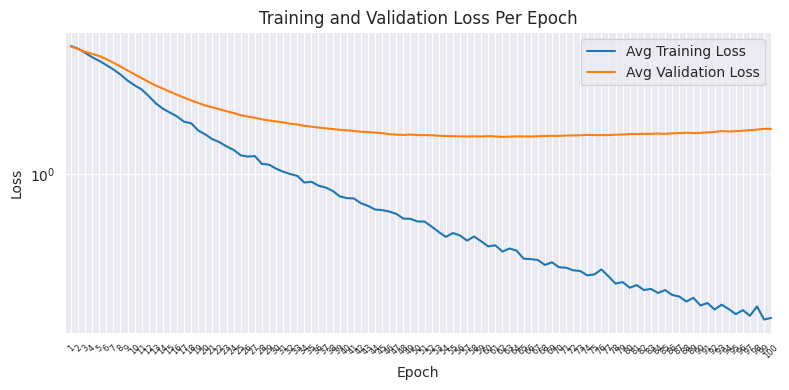

Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.57it/s]


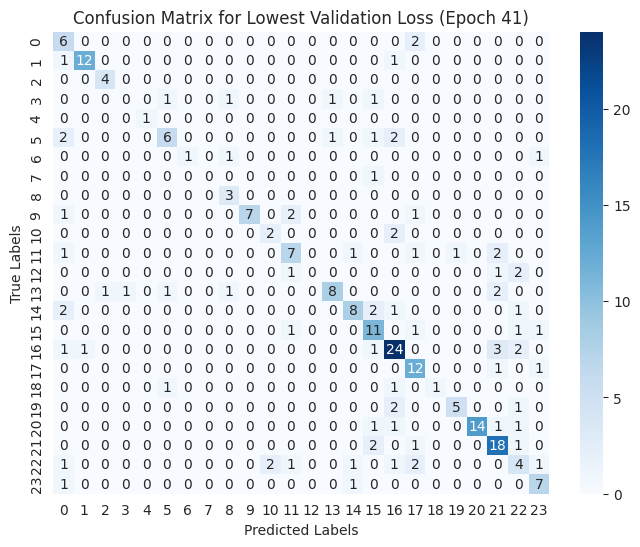

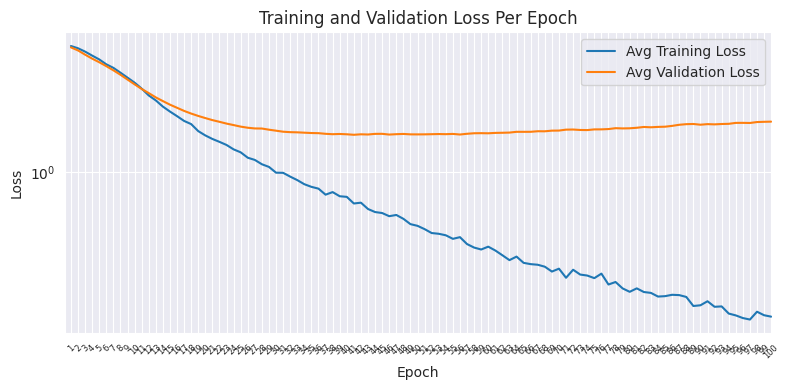

Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.47it/s]


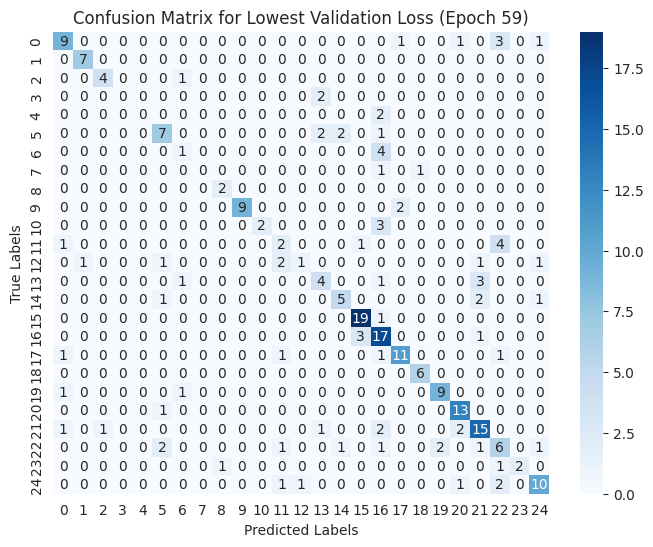

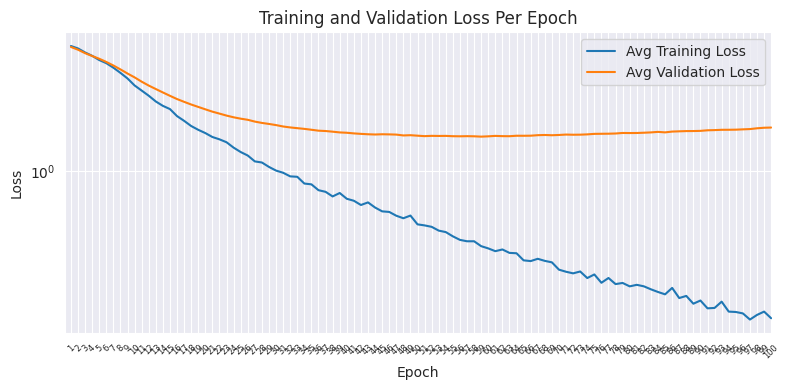

Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.31it/s]


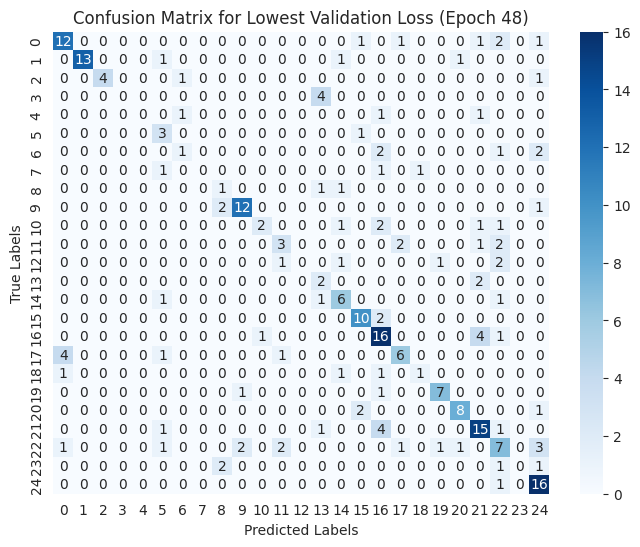

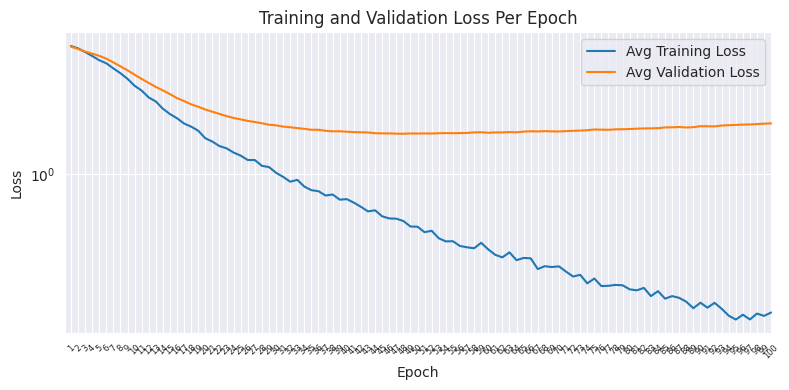

In [ ]:
# vectorizing cleaned columns
text = df['Cleaned_Resume'].values
target = df['Target'].values

# initialize label encoder and transform target labels
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=False,
    stop_words='english',
    max_features=500
)
tfidf_vectorizer.fit(raw_documents=text)
features_train = tfidf_vectorizer.transform(raw_documents=text)

# define K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# metrics storage
train_accuracies = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# initializing the list to collect misclassified resumes
misclassified_resumes = []

# K-Fold Cross Validation loop
for train_index, test_index in kf.split(features_train):
    # splitting data into folds
    X_train_fold, X_test_fold = features_train[train_index], features_train[test_index]
    y_train_fold, y_test_fold = target_encoded[train_index], target_encoded[test_index]

    # convert to tensors
    X_train_tensor = torch.tensor(X_train_fold.toarray(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_fold.toarray(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_fold, dtype=torch.long)

    # DataLoader for training and validation sets
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor), batch_size=MLP_BATCH_SIZE, shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(X_test_tensor, y_test_tensor), batch_size=MLP_BATCH_SIZE, shuffle=False
    )

    # model initialization
    mlp_model = make_mlp(
        input_dim=X_train_fold.shape[1],
        hidden_dims=MLP_HIDDEN_DIMS_LIST,
        output_dim=len(label_encoder.classes_),
        dropout=MLP_DROPOUT
    )
    mlp_model.to(device)

    # loss function and optimizer
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=MLP_LEARNING_RATE)

    # train and validate model
    best_train_true, best_train_preds, best_val_true, best_val_preds = train_and_validate_mlp(
        mlp_model=mlp_model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        loss_function=loss_function,
        device=device,
        epochs=MLP_NUM_EPOCHS
    )

    # checking for misclassified resumes
    for i, (true, pred) in enumerate(zip(best_val_true, best_val_preds)):
        if true != pred:
            # getting original index from dataset
            misclassified_idx = test_index[i]
            misclassified_resumes.append(
                {
                    'Text': df.loc[misclassified_idx, 'Cleaned_Resume'],
                    'True_Label': label_encoder.inverse_transform([true])[0],
                    'Pred_Label': label_encoder.inverse_transform([pred])[0]
                }
            )

    # calculate and store metrics
    train_accuracy = accuracy_score(best_train_true, best_train_preds)
    val_accuracy = accuracy_score(best_val_true, best_val_preds)
    val_precision = precision_score(best_val_true, best_val_preds, average='weighted')
    val_recall = recall_score(best_val_true, best_val_preds, average='weighted')
    val_f1 = f1_score(best_val_true, best_val_preds, average='weighted')

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

In [ ]:
# print average results from cross-validation
print("Average training accuracy:", np.mean(train_accuracies))
print("Average validation accuracy:", np.mean(val_accuracies))
print("Average validation precision:", np.mean(val_precisions))
print("Average validation recall:", np.mean(val_recalls))
print("Average validation F1-score:", np.mean(val_f1_scores))

Average training accuracy: 0.9401158049600673
Average validation accuracy: 0.6439317277204345
Average validation precision: 0.6397729987623817
Average validation recall: 0.6439317277204345
Average validation F1-score: 0.6241561850310606


In [ ]:
# print misclassified resumes
for i, misclassified in enumerate(misclassified_resumes, 1):
    text = misclassified['Text']
    pred_idx = misclassified['Pred_Label']
    true_idx = misclassified['True_Label']

    print("Misclassified Resume:")
    print(f"\t Text: \"{text}\"")
    print(f"\t\t- y_pred = {pred_idx}")
    print(f"\t\t- y_true = {true_idx}")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##### 5.2.2) MLP Classifier, Word2Vec Vectorization

In [ ]:
# tokenize and preprocess the text
df['tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: simple_preprocess(
        doc = resume
    )
)

# train Word2Vec model
model = Word2Vec(
    sentences = df['tokenized'],
    vector_size = 50,
    window = 3,
    min_count = 1,
    workers = 4,
    sg = 1
)

# define function to create a vector for a document
def document_vector(
    doc: List[str],
    vector_size: int,
    model
) -> np.ndarray:
    """
    Purpose: Generates a document vector by averaging the word vectors of the words in the document.
    :param doc: List[str] representing tokenized words in a document.
    :param vector_size: int representing dimensionality of the word vectors in the model.
    :param model: gensim.models.KeyedVectors representing the pre-trained Word2Vec model.
    :return: np.ndarray representing the averaged vector of the document's words.
    """
    # remove out-of-vocabulary words
    valid_words = [
       word for word in doc if word in model.wv.index_to_key
    ]
    if valid_words:
        return np.mean(
            model.wv[valid_words],
            axis = 0
        )
    else:
        return np.zeros(vector_size)

# create document vectors for each resume
df['doc_vector'] = df['tokenized'].apply(
    lambda tokenized_resume: document_vector(
        doc = tokenized_resume,
        model = model,
        vector_size=50
    )
)

# prepare data for modeling
X_word2vec = np.array(
    df['doc_vector'].tolist()
)
y = df['Category']

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(
    y
)

Epochs: 100%|██████████| 100/100 [00:05<00:00, 19.92it/s]


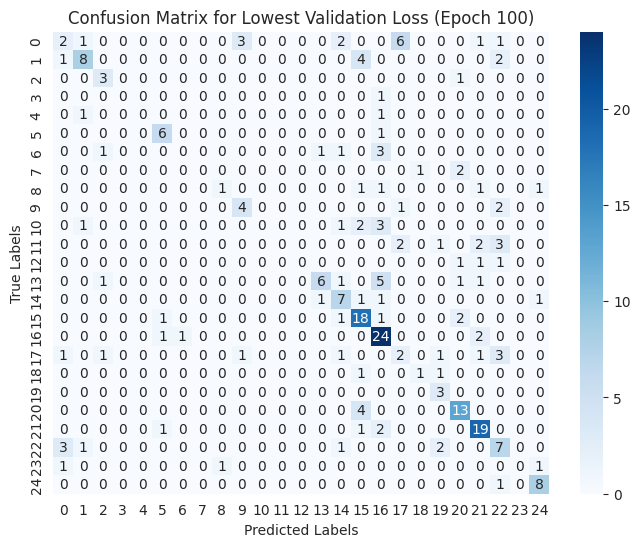

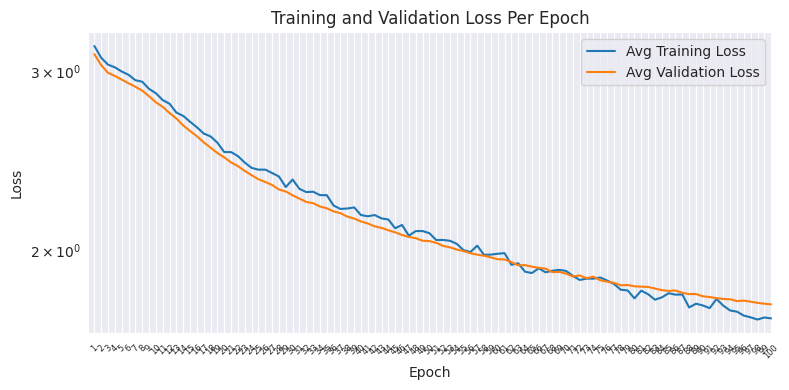

Epochs: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


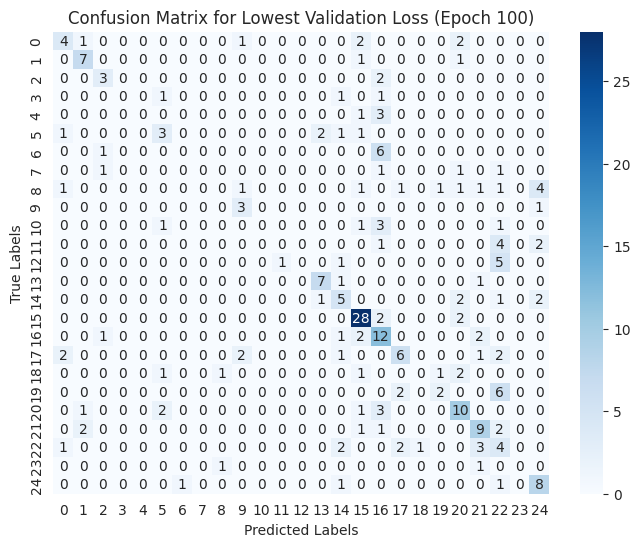

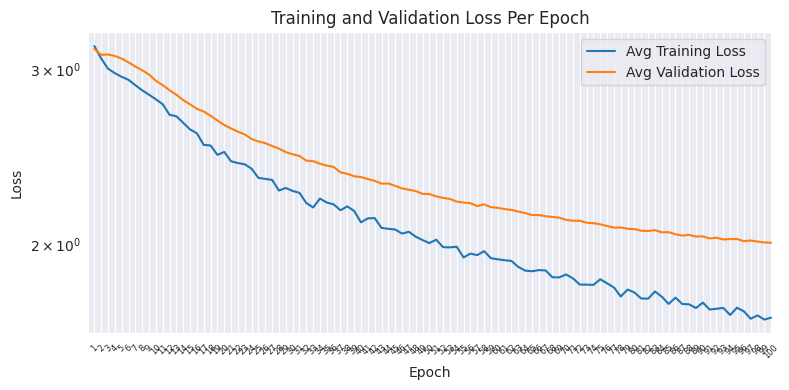

Epochs: 100%|██████████| 100/100 [00:04<00:00, 24.15it/s]


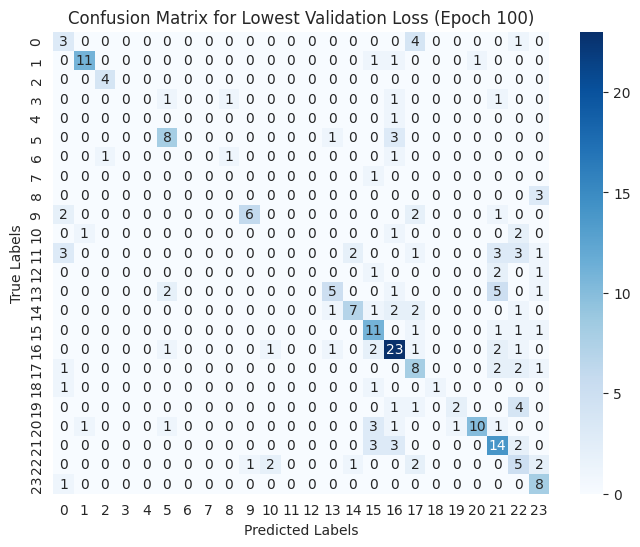

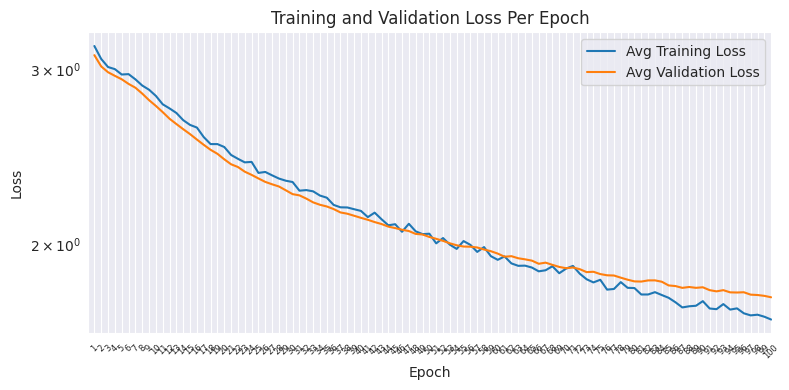

Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.99it/s]


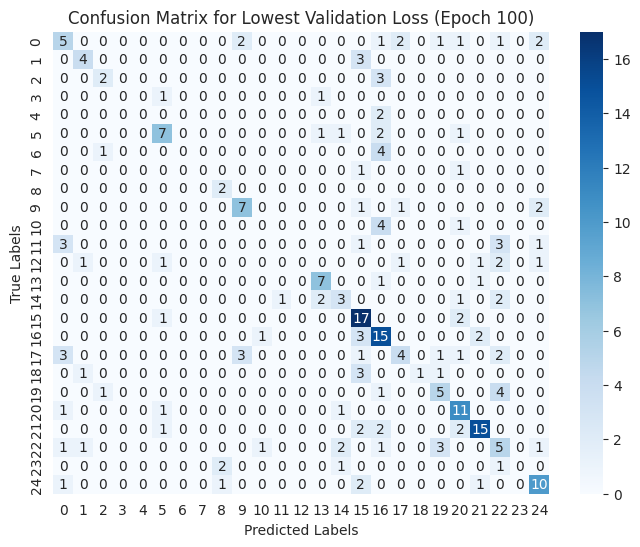

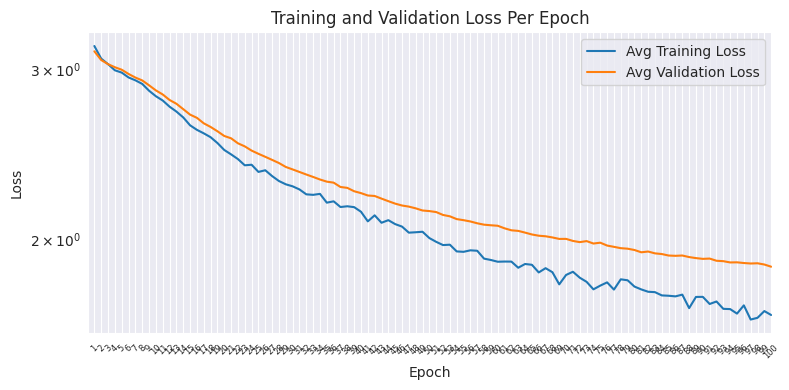

Epochs: 100%|██████████| 100/100 [00:04<00:00, 24.02it/s]


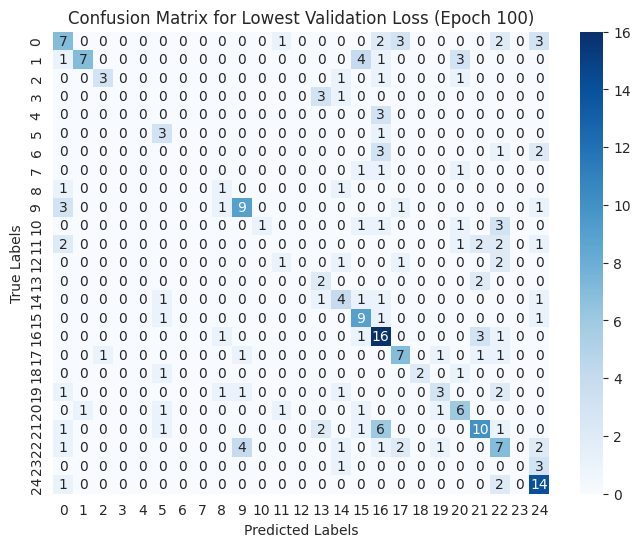

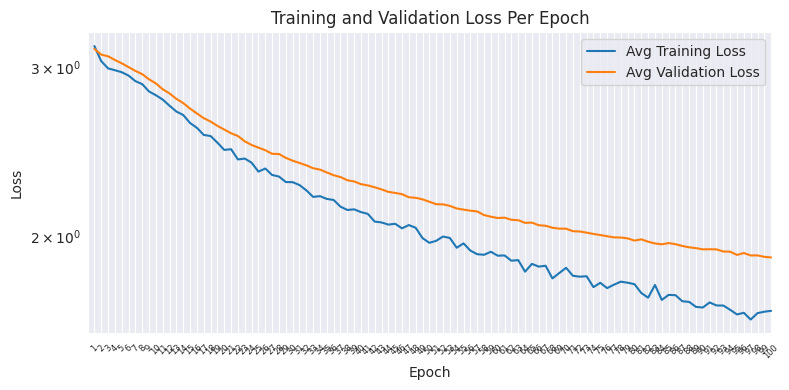

In [ ]:
# initialize cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# metrics storage
train_accuracies = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# initializing the list to collect misclassified resumes
misclassified_resumes = []

# K-Fold Cross Validation loop
for train_index, test_index in kf.split(X_word2vec):
    X_train, X_val = X_word2vec[train_index], X_word2vec[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    # convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # DataLoader for training and validation sets
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=MLP_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=MLP_BATCH_SIZE, shuffle=False)

    # initialize model
    mlp_model = make_mlp(input_dim=50, hidden_dims=MLP_HIDDEN_DIMS_LIST, output_dim=len(set(y_encoded)), dropout=MLP_DROPOUT)
    mlp_model.to(device)

    # loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=MLP_LEARNING_RATE)

    # train and validate model
    _, _, best_val_true, best_val_preds = train_and_validate_mlp(
        mlp_model=mlp_model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        loss_function=loss_function,
        device=device,
        epochs=MLP_NUM_EPOCHS
    )

    # checking for misclassified resumes
    for i, (true, pred) in enumerate(zip(best_val_true, best_val_preds)):
        if true != pred:
            # getting original index from dataset
            misclassified_idx = test_index[i]
            misclassified_resumes.append(
                {
                    'Text': df.loc[misclassified_idx, 'Cleaned_Resume'],
                    'True_Label': label_encoder.inverse_transform([true])[0],
                    'Pred_Label': label_encoder.inverse_transform([pred])[0]
                }
            )

    # metrics calculation
    val_accuracy = accuracy_score(y_true=best_val_true, y_pred=best_val_preds)
    val_precision = precision_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')
    val_recall = recall_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')
    val_f1 = f1_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')

    # store metrics
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

In [ ]:
# output average results
print("Average Validation Accuracy: {:.2f}%".format(np.mean(val_accuracies) * 100))
print("Average Validation Precision: {:.2f}%".format(np.mean(val_precisions) * 100))
print("Average Validation Recall: {:.2f}%".format(np.mean(val_recalls) * 100))
print("Average Validation F1 Score: {:.2f}%".format(np.mean(val_f1_scores) * 100))

Average Validation Accuracy: 49.22%
Average Validation Precision: 44.94%
Average Validation Recall: 49.22%
Average Validation F1 Score: 45.05%


In [ ]:
# print misclassified resumes
for i, misclassified in enumerate(misclassified_resumes, 1):
    text = misclassified['Text']
    pred_idx = misclassified['Pred_Label']
    true_idx = misclassified['True_Label']

    print("Misclassified Resume:")
    print(f"\t Text: \"{text}\"")
    print(f"\t\t- y_pred = {pred_idx}")
    print(f"\t\t- y_true = {true_idx}")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##### 5.2.3) MLP Classifier, GloVe Vectorization

In [ ]:
# tokenize and preprocess the text
df['tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: word_tokenize(text=resume)
)

# vectorize resumes using GloVe
df['Vec_Resume_Glove'] = df['Cleaned_Resume'].apply(
    lambda resume: vectorize_text(text=resume, model=model_glove)
)

# prepare data for modeling
X_glove = np.array(df['Vec_Resume_Glove'].tolist())
y = df['Category']

# encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.06it/s]


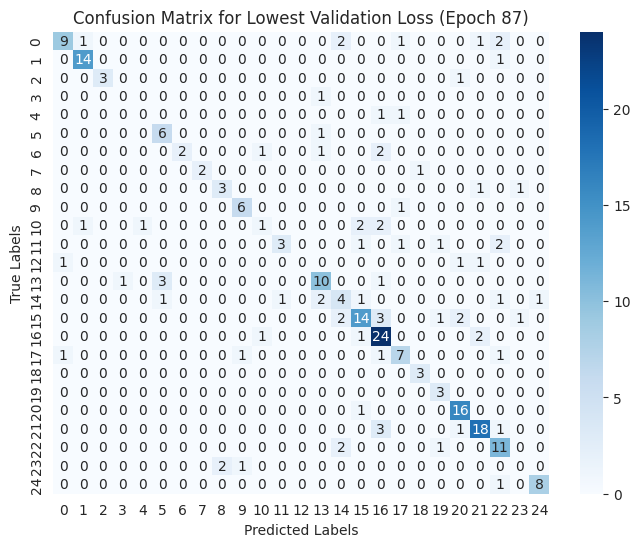

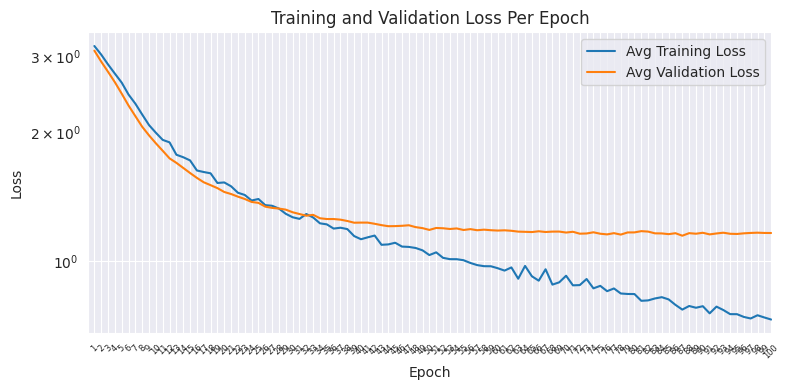

Epochs: 100%|██████████| 100/100 [00:04<00:00, 21.32it/s]


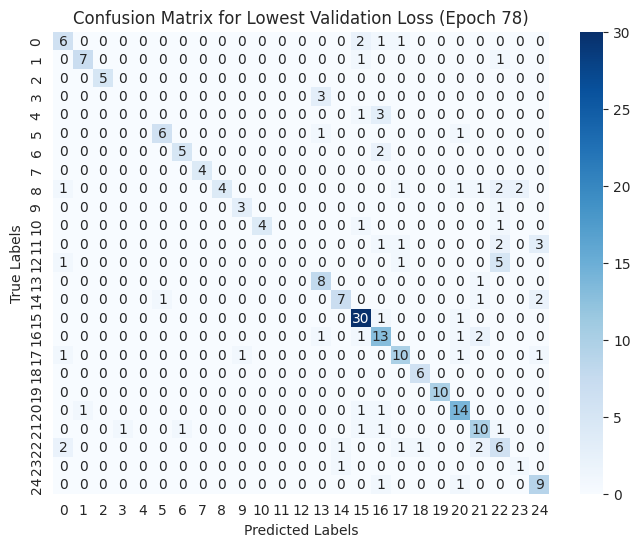

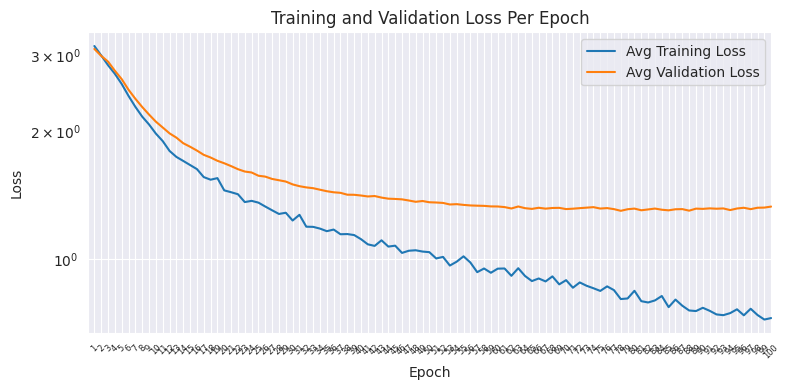

Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.81it/s]


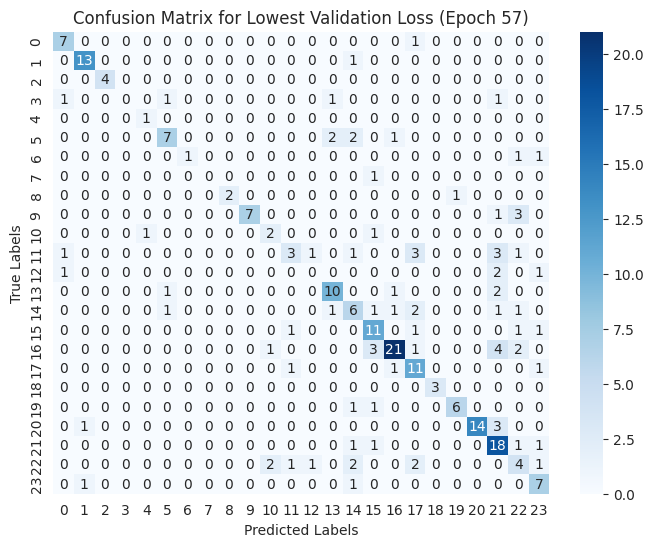

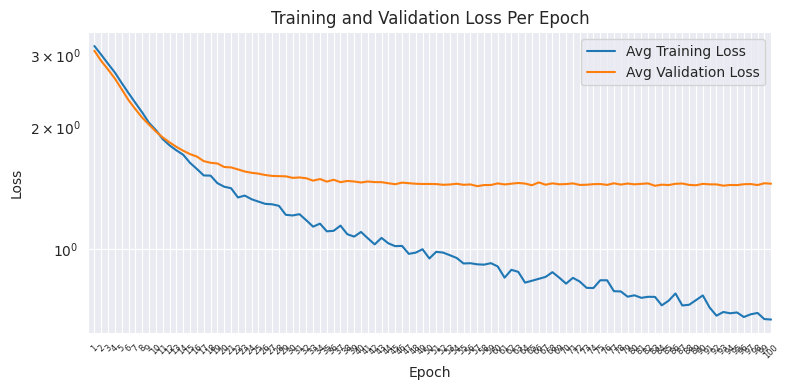

Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.99it/s]


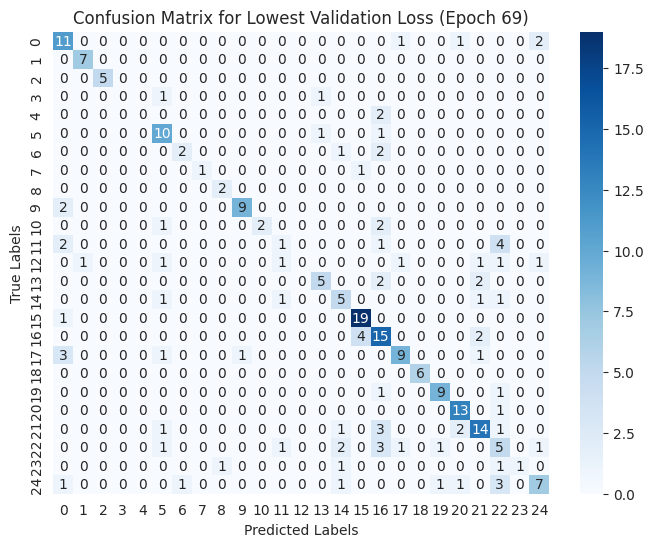

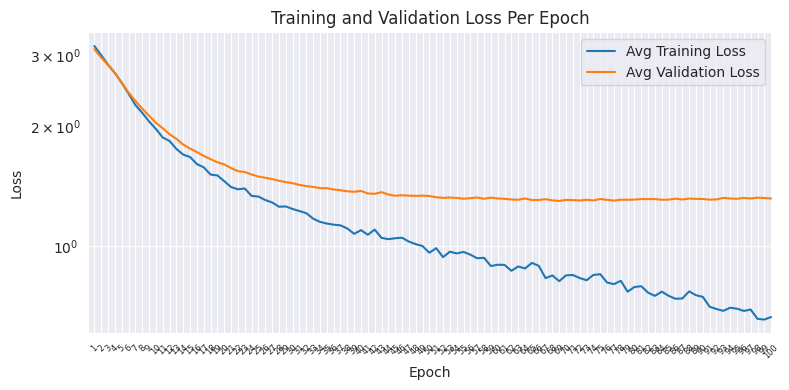

Epochs: 100%|██████████| 100/100 [00:04<00:00, 21.11it/s]


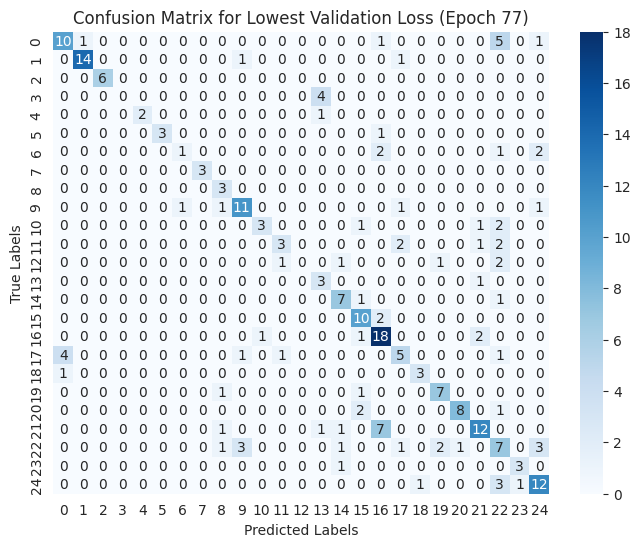

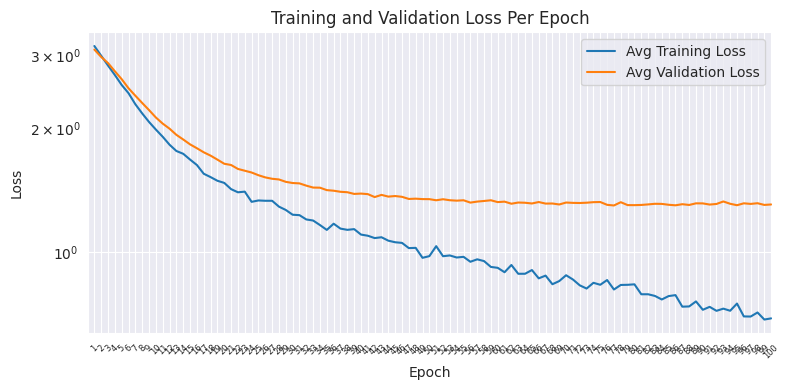

In [ ]:
# initialize cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# metrics storage
train_accuracies = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# initializing the list to collect misclassified resumes
misclassified_resumes = []

# K-Fold Cross Validation loop
for train_index, test_index in kf.split(X_glove):
    X_train, X_val = X_glove[train_index], X_glove[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    # convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # DataLoader for training and validation sets
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=MLP_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=MLP_BATCH_SIZE, shuffle=False)

    # initialize model
    mlp_model = make_mlp(input_dim=X_train.shape[1], hidden_dims=MLP_HIDDEN_DIMS_LIST, output_dim=len(set(y_encoded)), dropout=MLP_DROPOUT)
    mlp_model.to(device)

    # loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=MLP_LEARNING_RATE)

    # train and validate model
    _, _, best_val_true, best_val_preds = train_and_validate_mlp(
        mlp_model=mlp_model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        loss_function=loss_function,
        device=device,
        epochs=MLP_NUM_EPOCHS
    )

    # checking for misclassified resumes
    for i, (true, pred) in enumerate(zip(best_val_true, best_val_preds)):
        if true != pred:
            # getting original index from dataset
            misclassified_idx = test_index[i]
            misclassified_resumes.append(
                {
                    'Text': df.loc[misclassified_idx, 'Cleaned_Resume'],
                    'True_Label': label_encoder.inverse_transform([true])[0],
                    'Pred_Label': label_encoder.inverse_transform([pred])[0]
                }
            )

    # metrics calculation
    val_accuracy = accuracy_score(y_true=best_val_true, y_pred=best_val_preds)
    val_precision = precision_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')
    val_recall = recall_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')
    val_f1 = f1_score(y_true=best_val_true, y_pred=best_val_preds, average='weighted')

    # store metrics
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

In [ ]:
# output average results
print("Average Validation Accuracy: {:.2f}%".format(np.mean(val_accuracies) * 100))
print("Average Validation Precision: {:.2f}%".format(np.mean(val_precisions) * 100))
print("Average Validation Recall: {:.2f}%".format(np.mean(val_recalls) * 100))
print("Average Validation F1 Score: {:.2f}%".format(np.mean(val_f1_scores) * 100))

Average Validation Accuracy: 66.04%
Average Validation Precision: 65.61%
Average Validation Recall: 66.04%
Average Validation F1 Score: 64.31%


In [ ]:
# print misclassified resumes
for i, misclassified in enumerate(misclassified_resumes, 1):
    text = misclassified['Text']
    pred_idx = misclassified['Pred_Label']
    true_idx = misclassified['True_Label']

    print("Misclassified Resume:")
    print(f"\t Text: \"{text}\"")
    print(f"\t\t- y_pred = {pred_idx}")
    print(f"\t\t- y_true = {true_idx}")

Output hidden; open in https://colab.research.google.com to view.

#### 5.3) Classification via SVM

##### 5.3.1) SVM Classifier, TF-IDF Vectorization

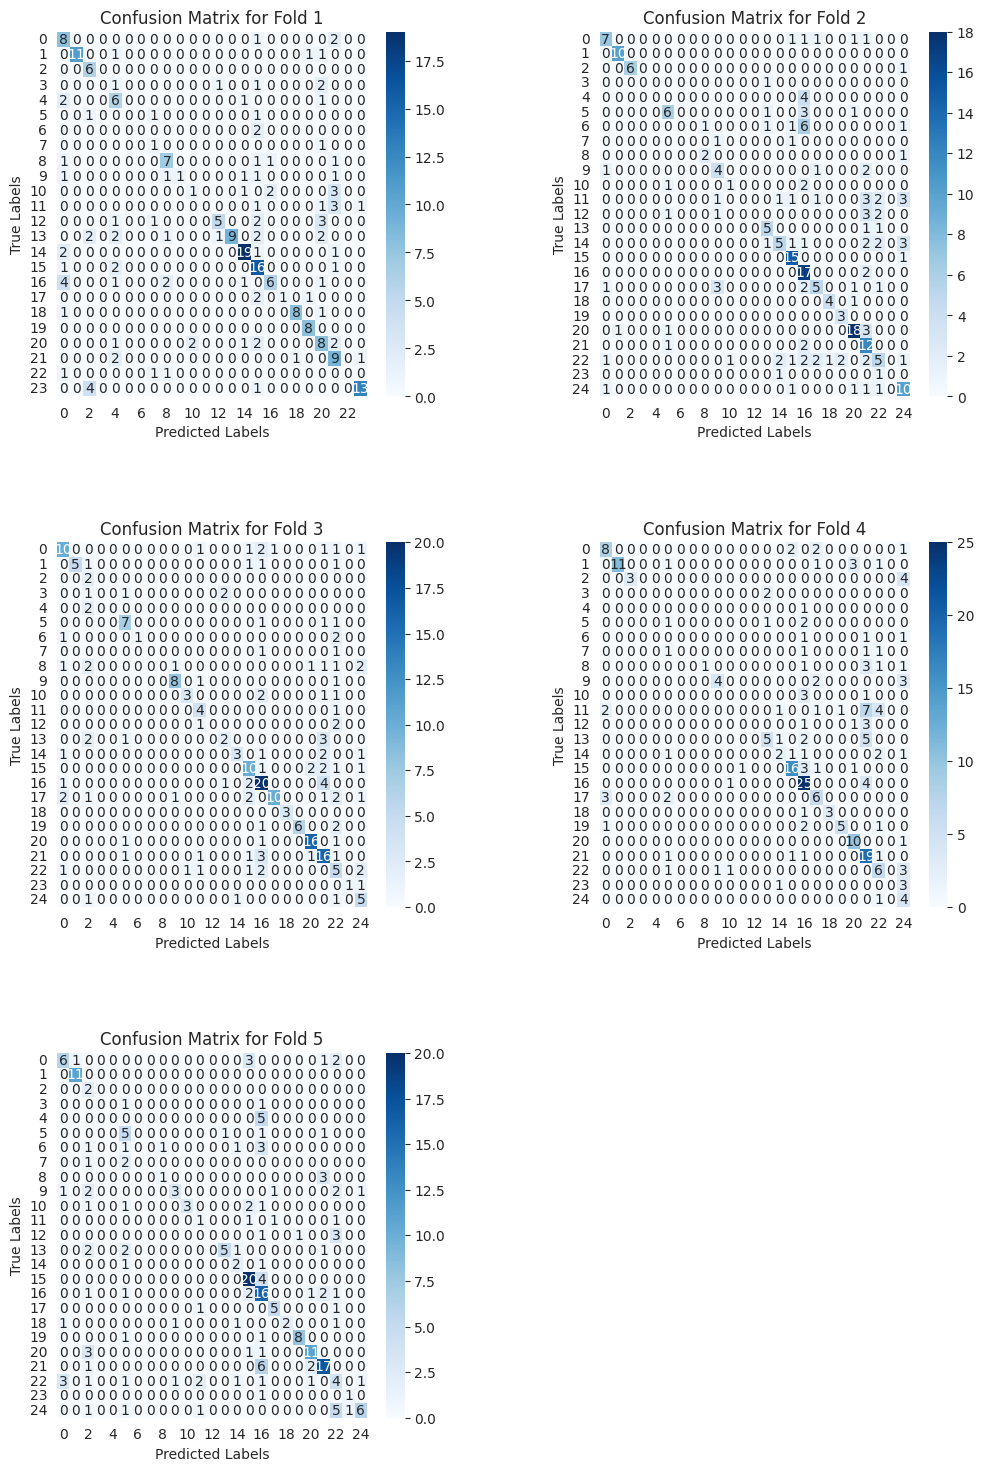

In [ ]:
# vectorizing cleaned columns
text = df['Cleaned_Resume'].values
target = df['Target'].values

tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=False,
    stop_words='english',
    max_features=500
)
features = tfidf_vectorizer.fit_transform(raw_documents=text)

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(target)

# define CV procedure
cv = KFold(n_splits=5, random_state=24, shuffle=True)

# define model
svm_model_tfidf = SVC(kernel='linear', probability=True, random_state=42)

# store each fold's performance metrics
accuracies, precisions, recalls, f1_scores = [], [], [], []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(features)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # train model
    svm_model_tfidf.fit(X_train, y_train)

    # prediction
    y_pred = svm_model_tfidf.predict(X_test)

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# hiding any unused subplots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')

plt.show()

In [ ]:
# calculate and print average performance metrics
print(f"Average Validation Accuracy: {np.mean(accuracies) * 100:.1f}%")
print(f"Average Validation Precision: {np.mean(precisions) * 100:.1f}%")
print(f"Average Validation Recall: {np.mean(recalls) * 100:.1f}%")
print(f"Average Validation F1 Score: {np.mean(f1_scores) * 100:.1f}%")

Average Validation Accuracy: 55.2%
Average Validation Precision: 56.0%
Average Validation Recall: 55.2%
Average Validation F1 Score: 52.7%


##### 5.3.2) SVM Classifier, Word2Vec Vectorization

In [ ]:
# train Word2Vec model
model = Word2Vec(
    sentences = df['tokenized'],
    vector_size = 50,
    window = 3,
    min_count = 1,
    workers = 4,
    sg = 1
)

# define function to create a vector for a document
def document_vector(
    doc: List[str]
) -> np.ndarray:
    """
    Purpose: Generates a document vector by averaging the word vectors of the words in the document.
    :param doc: List[str] representing tokenized words in a document.
    :return: np.ndarray representing the averaged vector of the document's words.
    """
    # remove out-of-vocabulary words
    doc = [
        word for word in doc if word in model.wv.index_to_key
    ]
    return np.mean(
        model.wv[doc],
        axis = 0
    )

# create document vectors for each resume
df['doc_vector'] = df['tokenized'].apply(
    lambda tokenized_resume: document_vector(
        doc = tokenized_resume
    )
)

In [ ]:
# prep data for modeling
X_word2vec = np.array(df['doc_vector'].tolist())
y = df['Category']

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(y)

# define model
svm_model = SVC(kernel='linear', probability=True, random_state=42)

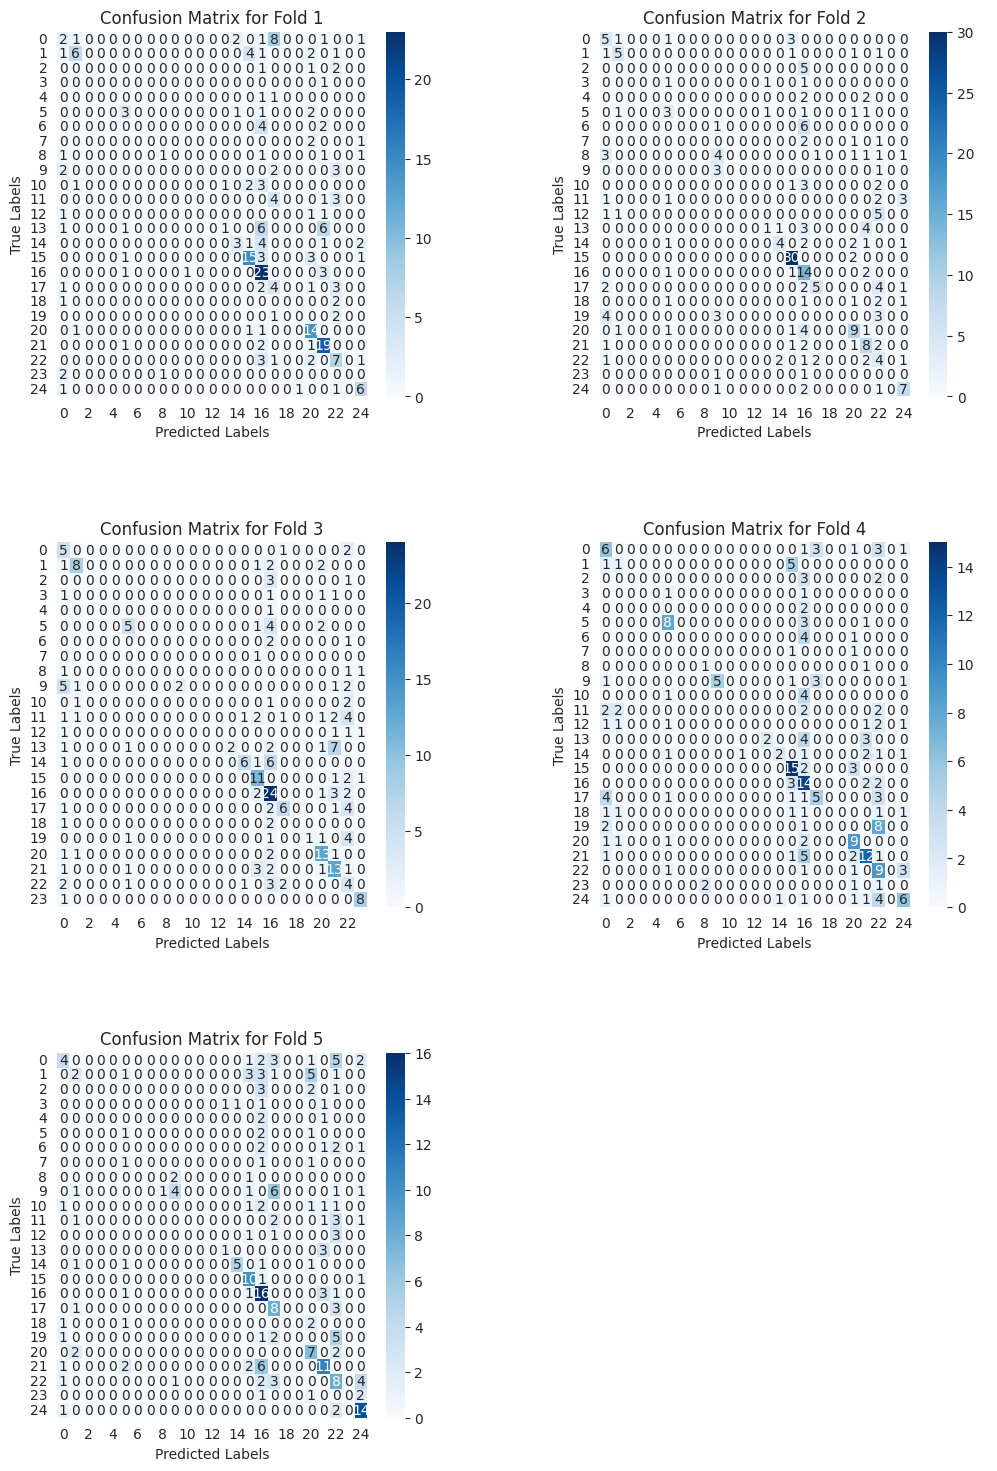

Average Validation Accuracy: 40.7%
Average Validation Precision: 36.8%
Average Validation Recall: 40.7%
Average Validation F1 Score: 35.2%


In [ ]:
# define CV procedure
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# store each fold's performance metrics
accuracies, precisions, recalls, f1_scores = [], [], [], []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(X_word2vec)):
    X_train, X_test = X_word2vec[train_index], X_word2vec[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # train model
    svm_model.fit(X_train, y_train)

    # prediction
    y_pred = svm_model.predict(X_test)

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# hiding any unused subplots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')

plt.show()

# Calculate and print average performance metrics
print(f"Average Validation Accuracy: {np.mean(accuracies) * 100:.1f}%")
print(f"Average Validation Precision: {np.mean(precisions) * 100:.1f}%")
print(f"Average Validation Recall: {np.mean(recalls) * 100:.1f}%")
print(f"Average Validation F1 Score: {np.mean(f1_scores) * 100:.1f}%")

##### 5.3.3) SVM Classifier, GloVe Vectorization

In [ ]:
# Tokenize and preprocess the text
df['tokenized'] = df['Cleaned_Resume'].apply(
    lambda resume: word_tokenize(
        text = resume
    )
)

# vectorize resumes using GloVe
df['Vec_Resume_Glove'] = df['Cleaned_Resume'].apply(
    lambda resume: vectorize_text(
        text = resume,
        model = model_glove
    )
)

In [ ]:
# prepare data for modeling
X_glove = np.array(
    df['Vec_Resume_Glove'].tolist()
)
y = df['Category']

# encode target variable
label = LabelEncoder()
y_encoded = label.fit_transform(
    y
)

In [ ]:
# define model
svm_model_glove = SVC(kernel='linear', probability=True, random_state=42)

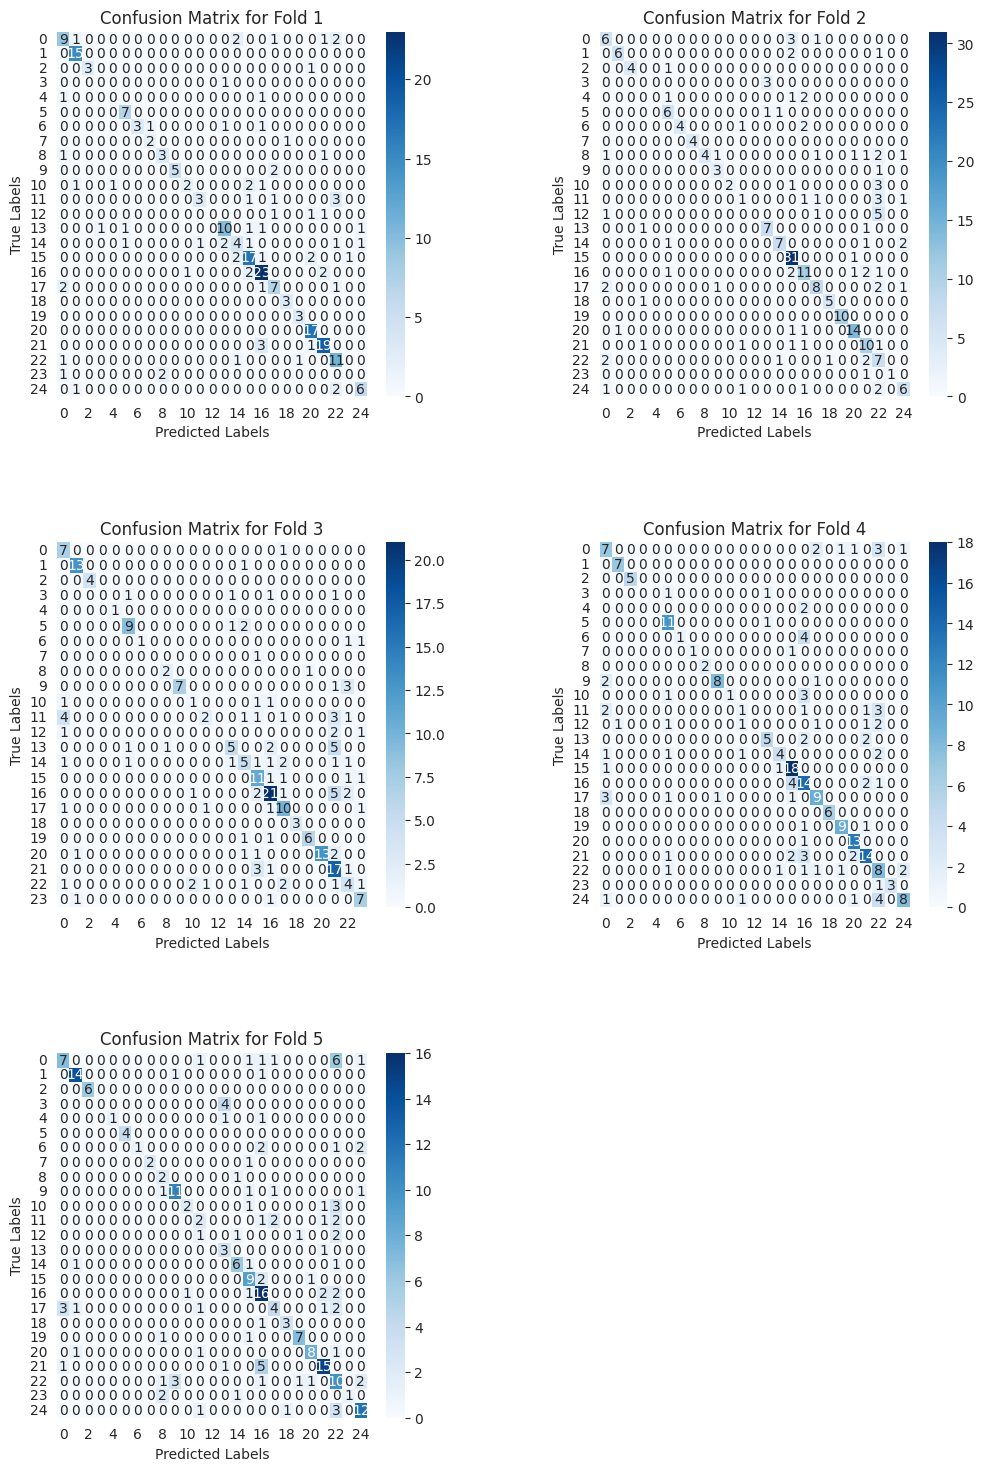

In [ ]:
# define CV procedure
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# store each fold's performance metrics
accuracies, precisions, recalls, f1_scores = [], [], [], []

# prep confusion matrix plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# perform manual K-Fold CV
for i, (train_index, test_index) in enumerate(cv.split(X_glove)):
    X_train, X_test = X_glove[train_index], X_glove[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # train model
    svm_model_glove.fit(X_train, y_train)

    # prediction
    y_pred = svm_model_glove.predict(X_test)

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # plot confusion matrix
    ax = axes.flatten()[i]
    sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Fold {i + 1}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# hiding any unused subplots
for j in range(i + 1, axes.size):
    axes.flatten()[j].axis('off')

plt.show()

In [ ]:
# calculate and print average performance metrics
print(f"Average Validation Accuracy: {np.mean(accuracies) * 100:.1f}%")
print(f"Average Validation Precision: {np.mean(precisions) * 100:.1f}%")
print(f"Average Validation Recall: {np.mean(recalls) * 100:.1f}%")
print(f"Average Validation F1 Score: {np.mean(f1_scores) * 100:.1f}%")

Average Validation Accuracy: 63.9%
Average Validation Precision: 64.8%
Average Validation Recall: 63.9%
Average Validation F1 Score: 62.3%


### **6. Observations and Discussion**

#### 6.1) Analysis of Model-Embedding Pair Performance

|    Model    |  Embedding  | Training Accuracy | Validation Accuracy |
|-------------|-------------|-------------------|---------------------|
| One-vs-Rest |   TF-IDF    |       59.0%       |        37.4%        |
| One-vs-Rest |  Word2Vec   |       62.6%       |        45.0%        |
| One-vs-Rest |    GloVe    |       66.9%       |        54.8%        |
|     MLP     |   TF-IDF    |       94.0%       |        64.4%        |
|     MLP     |  Word2Vec   |       51.0%       |        49.2%        |
|     MLP     |    GloVe    |       79.4%       |        66.0%        |
|     SVM     |   TF-IDF    |       73.1%       |        55.2%        |
|     SVM     |  Word2Vec   |       43.8%       |        40.7%        |
|     SVM     |    GloVe    |       77.1%       |        63.9%        |



Looking at the performance of various model-embedding combinations reveals significant variations in both training and validation accuracies, suggesting that the choice of embedding has a profound impact on model efficacy. The One-vs-Rest classifier shows modest performance across all embeddings, with GloVe leading at a 54.8% validation accuracy, indicating a better but still limited capability in handling complex class distinctions compared to other models. In contrast, the MLP model demonstrates a high training accuracy with TF-IDF at 94.0%, but this does not translate as effectively into validation accuracy, which peaks at 66.0% with GloVe, pointing to potential overfitting issues with simpler embeddings like TF-IDF and Word2Vec.

Similarly, the SVM model achieves its best results with GloVe at 63.9% validation accuracy, which, although higher compared to its performance with TF-IDF and Word2Vec, suggests a challenging dataset or possible limitations in the model's ability to generalize from training to unseen data. These insights emphasize that while GloVe consistently presents a more robust feature representation, enabling better performance across different models, the overall lower validation accuracies across all combinations highlight the necessity for careful matching of model architectures and embeddings to the specific characteristics of the dataset to optimize effectiveness and efficiency in practical applications.

#### 6.2) Analysis of Frequently Misclassified Resumes

In reviewing the misclassifications from different setups of the MLP classifier using TF-IDF, Word2Vec, and GloVe vectorizations, some trends emerge that explain why certain resumes were categorized incorrectly. For example, in the MLP using TF-IDF, many specialized jobs like photographers were mistakenly grouped under broader categories like "Arts" instead of more specific ones like "Designing". This suggests that while TF-IDF is good at picking up common words, it might miss the finer details that set different jobs apart, which can confuse the model when jobs share similar skills or tools.

Similarly, in setups using Word2Vec and GloVe, the errors often involved resumes that mixed technical and creative skills, leading to wrong labels. For instance, a resume that should have been categorized under "Arts" was labeled as "Designing" because of the mix-up between technical skills and creative job elements. This highlights a challenge in training models to understand job context properly and shows the need for better ways to handle the nuances in how job skills are presented. These misclassifications point out that even though these models are advanced, distinguishing between closely related job fields can still be tricky.